In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") 

Using device: cuda


In [3]:
# Define dataset paths
base_dir = "MURA-v1.1"  # Update this to the root directory of your dataset


In [4]:
# CSV files for train and validation datasets
train_images_csv = os.path.join(base_dir, "train_image_paths.csv")  # Update with actual filename
train_labels_csv = os.path.join(base_dir, "train_labeled_studies.csv")  # Update with actual filename
valid_images_csv = os.path.join(base_dir, "valid_image_paths.csv")  # Update with actual filename
valid_labels_csv = os.path.join(base_dir, "valid_labeled_studies.csv")  # Update with actual filename

In [5]:
df_train_images = pd.read_csv(train_images_csv, header=None)
df_train_labels = pd.read_csv(train_labels_csv, header=None)
df_valid_images = pd.read_csv(valid_images_csv, header=None)
df_valid_labels = pd.read_csv(valid_labels_csv, header=None)


In [6]:
# FIX: Print some sample paths to debug
print("Sample image path from CSV:", df_train_images[0].iloc[0])
print("Full path that would be constructed:", os.path.join(df_train_images[0].iloc[0]))

Sample image path from CSV: MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
Full path that would be constructed: MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png


In [7]:
train_label_dict = dict(zip(df_train_labels[0], df_train_labels[1]))
valid_label_dict = dict(zip(df_valid_labels[0], df_valid_labels[1]))

def get_label(image_path, label_dict):
    study_path = "/".join(image_path.split("/")[:-1]) + "/"  # Extract study path
    return label_dict.get(study_path, -1)  # Default label -1 if not found

In [8]:
# Apply label extraction
df_train_images["label"] = df_train_images[0].apply(lambda x: get_label(x, train_label_dict))
df_valid_images["label"] = df_valid_images[0].apply(lambda x: get_label(x, valid_label_dict))

In [9]:
class MURADataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # ✅ Ensure path is correctly formatted (normalize path)
        img_path = os.path.normpath(img_path)

        # ✅ If path doesn't exist, try adding base_dir
        if not os.path.exists(img_path):
            img_path = os.path.normpath(os.path.join(base_dir, img_path))

        # ✅ If still missing, return placeholder
        if not os.path.exists(img_path):
            print(f"❌ File missing: {img_path}")
            placeholder = torch.zeros((3, 224, 224))  # Return black image
            return placeholder, torch.tensor(-1, dtype=torch.long)

        label = self.labels[idx]

        try:
            # ✅ Load image safely
            image = Image.open(img_path).convert("RGB")

            # ✅ Apply transformations
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"❌ Error loading {img_path}: {e}")
            placeholder = torch.zeros((3, 224, 224))  # Return black image
            return placeholder, torch.tensor(-1, dtype=torch.long)

In [10]:
# ✅ Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for RGB
])

In [11]:
# ✅ Function to check dataset paths
def check_dataset_paths(base_dir, sample_paths, num_samples=5):
    print("\n--- Dataset Path Check ---")
    
    paths_to_check = [
        base_dir,
        os.path.join(os.getcwd(), base_dir),
        os.path.dirname(base_dir),
        os.path.join(os.getcwd(), os.path.dirname(base_dir))
    ]
    
    for path in paths_to_check:
        if os.path.exists(path):
            print(f"✅ Found directory: {path}")
        else:
            print(f"❌ Directory not found: {path}")

    for i, path in enumerate(sample_paths[:num_samples]):
        norm_path = os.path.normpath(path)
        full_path = os.path.normpath(os.path.join(base_dir, path))

        if os.path.exists(norm_path):
            print(f"✅ Sample {i+1}: File exists at {norm_path}")
        elif os.path.exists(full_path):
            print(f"✅ Sample {i+1}: File exists at {full_path}")
        else:
            print(f"❌ Sample {i+1}: File not found at {norm_path} or {full_path}")
    print("-------------------------\n")

In [12]:
# ✅ Run dataset path check
check_dataset_paths(base_dir, df_train_images[0].tolist())


--- Dataset Path Check ---
✅ Found directory: MURA-v1.1
✅ Found directory: D:\Sem 6 project\MURA-v1.1
❌ Directory not found: 
✅ Found directory: D:\Sem 6 project\
✅ Sample 1: File exists at MURA-v1.1\train\XR_SHOULDER\patient00001\study1_positive\image1.png
✅ Sample 2: File exists at MURA-v1.1\train\XR_SHOULDER\patient00001\study1_positive\image2.png
✅ Sample 3: File exists at MURA-v1.1\train\XR_SHOULDER\patient00001\study1_positive\image3.png
✅ Sample 4: File exists at MURA-v1.1\train\XR_SHOULDER\patient00002\study1_positive\image1.png
✅ Sample 5: File exists at MURA-v1.1\train\XR_SHOULDER\patient00002\study1_positive\image2.png
-------------------------



In [13]:
# ✅ Create datasets
train_dataset = MURADataset(df_train_images[0].tolist(), df_train_images["label"].tolist(), transform=transform)
valid_dataset = MURADataset(df_valid_images[0].tolist(), df_valid_images["label"].tolist(), transform=transform)

In [14]:
# ✅ Create DataLoaders (CPU optimized)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)


In [15]:
def show_batch(sample_batch):
    images, labels = sample_batch  
    valid_indices = [i for i, label in enumerate(labels) if label != -1]

    if not valid_indices:
        print("No valid images found in batch")
        return

    num_to_show = min(3, len(valid_indices))
    fig, axes = plt.subplots(1, num_to_show, figsize=(12, 5))

    if num_to_show == 1:
        axes = [axes]

    for i in range(num_to_show):
        idx = valid_indices[i]
        img = images[idx].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Denormalize
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {labels[idx].item()}")
        axes[i].axis("off")
    plt.show()


In [16]:
# ✅ Try loading a batch
try:
    print("Attempting to load a batch...")
    start = time.time()
    sample_batch = next(iter(train_loader))
    print(f"✅ Successfully loaded a batch in {time.time() - start:.2f} sec")
    show_batch(sample_batch)
except Exception as e:
    print(f"❌ Error loading batch: {e}")

Attempting to load a batch...
❌ Error loading batch: name 'time' is not defined


In [17]:
import seaborn as sns

In [18]:
# ✅ Extract categories from file paths
df_train_images["category"] = df_train_images[0].apply(lambda x: x.split("/")[1])
df_valid_images["category"] = df_valid_images[0].apply(lambda x: x.split("/")[1])

In [19]:
# ✅ Count the number of images per category
train_category_counts = df_train_images["category"].value_counts()
valid_category_counts = df_valid_images["category"].value_counts()

In [20]:
# ✅ Count the number of positive and negative cases
train_label_counts = df_train_images["label"].value_counts()
valid_label_counts = df_valid_images["label"].value_counts()

In [21]:
# ✅ Print summary statistics
print("🔹 Training Set Categories:\n", train_category_counts)
print("🔹 Validation Set Categories:\n", valid_category_counts)
print("\n🔹 Training Label Distribution:\n", train_label_counts)
print("🔹 Validation Label Distribution:\n", valid_label_counts)

🔹 Training Set Categories:
 category
train    36808
Name: count, dtype: int64
🔹 Validation Set Categories:
 category
valid    3197
Name: count, dtype: int64

🔹 Training Label Distribution:
 label
0    21935
1    14873
Name: count, dtype: int64
🔹 Validation Label Distribution:
 label
0    1667
1    1530
Name: count, dtype: int64


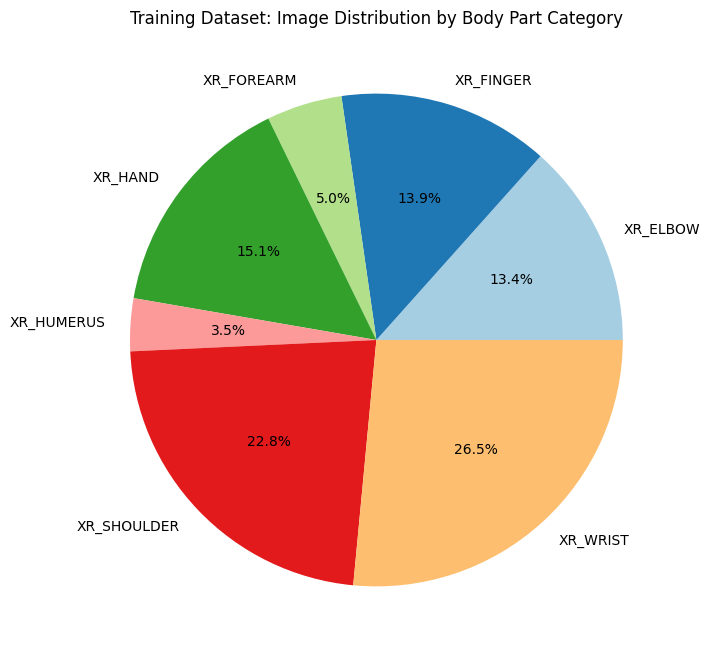

In [22]:

# Path to your dataset
train_dir = "MURA-v1.1/train"
# Get body part categories (folder names)
categories = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
# Count images per category
category_counts = {category: 0 for category in categories}
for category in categories:
    category_path = os.path.join(train_dir, category)
    for patient in os.listdir(category_path):
        patient_path = os.path.join(category_path, patient)
        for study in os.listdir(patient_path):
            study_path = os.path.join(patient_path, study)
            category_counts[category] += len(os.listdir(study_path))  # Count images

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    category_counts.values(),
    labels=category_counts.keys(),
    autopct='%1.1f%%',
    colors=plt.cm.Paired.colors
)
plt.title("Training Dataset: Image Distribution by Body Part Category")
plt.show()


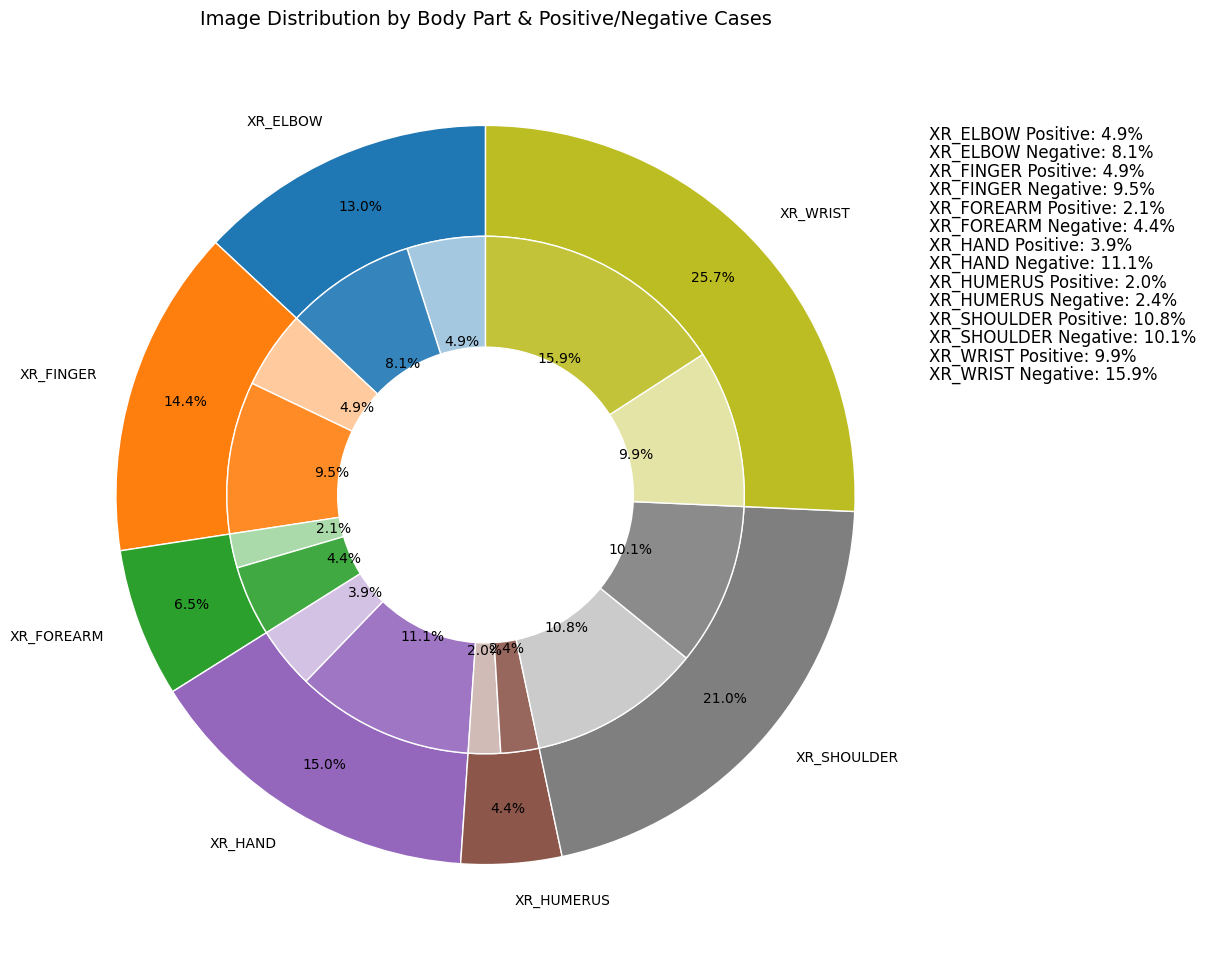

In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Path to your dataset
train_dir = "MURA-v1.1/train"

# Get body part categories (folder names)
categories = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Dictionary to store counts of positive & negative cases per category
category_counts = {category: {"positive": 0, "negative": 0} for category in categories}

# Count images per category (split into positive/negative)
for category in categories:
    category_path = os.path.join(train_dir, category)
    for patient in os.listdir(category_path):
        patient_path = os.path.join(category_path, patient)
        for study in os.listdir(patient_path):
            study_path = os.path.join(patient_path, study)
            if "positive" in study.lower():
                category_counts[category]["positive"] += len(os.listdir())
            elif "negative" in study.lower():
                category_counts[category]["negative"] += len(os.listdir())

# Preparing data for plotting
outer_labels = list(category_counts.keys())  # Body part categories
outer_sizes = [sum(vals.values()) for vals in category_counts.values()]  # Total images per category

inner_labels = []
inner_sizes = []
for category, counts in category_counts.items():
    inner_labels.append(f"{category} Positive")
    inner_sizes.append(counts["positive"])
    inner_labels.append(f"{category} Negative")
    inner_sizes.append(counts["negative"])

# Generate colors using tab10 colormap
base_colormap = plt.colormaps.get_cmap('tab10')  # Get main colormap
colors_outer = [base_colormap(i / len(outer_labels)) for i in range(len(outer_labels))]  # Distinct colors per category

# Ensure positive/negative shades are linked to the correct body parts
colors_inner = []
for i in range(len(outer_labels)):
    colors_inner.append((*colors_outer[i][:3], 0.4))  # Light shade for positive
    colors_inner.append((*colors_outer[i][:3], 0.9))  # Dark shade for negative

# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Outer Pie (Body Parts)
ax.pie(
    outer_sizes,
    labels=outer_labels,
    radius=1,
    wedgeprops=dict(width=0.3, edgecolor='white'),
    colors=colors_outer,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90
)

# Inner Pie (Positive/Negative)
inner_wedges, inner_texts, inner_autotexts = ax.pie(
    inner_sizes,
    
    radius=0.7,
    wedgeprops=dict(width=0.3, edgecolor='white'),
    colors=colors_inner,
    labeldistance=0.6,
    startangle=90,
    autopct='%1.1f%%'
)

# Extract percentage values for each inner section
percentages = [text.get_text() for text in inner_autotexts]

# List percentages outside the chart
for i, (label, perc) in enumerate(zip(inner_labels, percentages)):
    x = 1.2  # X coordinate outside the chart
    y = 1 - (i * 0.05)  # Y coordinate (spaced vertically)
    ax.text(x, y, f"{label}: {perc}", fontsize=12, ha='left', va='top')

# Title
ax.set_title("Image Distribution by Body Part & Positive/Negative Cases", fontsize=14)

# Show plot
plt.show()


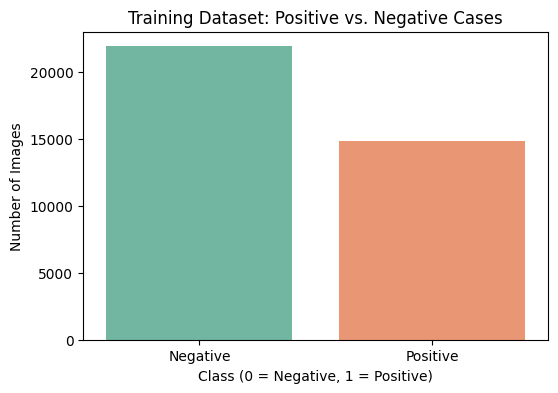

In [24]:
# ✅ Visualization: Positive vs. Negative Cases
plt.figure(figsize=(6, 4))
sns.barplot(x=train_label_counts.index.astype(str), y=train_label_counts.values, hue=train_label_counts.index.astype(str), palette="Set2", legend=False)
plt.xlabel("Class (0 = Negative, 1 = Positive)")
plt.ylabel("Number of Images")
plt.title("Training Dataset: Positive vs. Negative Cases")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()

### GAN

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Create directories for checkpoints and synthetic images
os.makedirs("MURA-v1.1/checkpoints", exist_ok=True)
os.makedirs("MURA-v1.1/synthetic", exist_ok=True)
os.makedirs("MURA-v1.1/synthetic/samples", exist_ok=True)

Using device: cuda


In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Scale to [-1, 1]
])

# Load the dataset (assuming train.csv is provided)
df_train_images = pd.read_csv("MURA-v1.1/train_image_paths.csv", header=None, names=["image_path"])
# Do not prepend "MURA-v1.1" since it's already in the CSV paths
df_train_images["label"] = df_train_images["image_path"].apply(lambda x: 1 if "positive" in x else 0)
df_train_images["category"] = df_train_images["image_path"].apply(lambda x: x.split('/')[2])

# Verify the dataset
print(f"Total images: {len(df_train_images)}")
print(df_train_images.head(10))

# Verify file existence for the first few paths
for path in df_train_images["image_path"].head():
    if not os.path.exists(path):
        print(f"File not found: {path}")
    else:
        print(f"File exists: {path}")

Total images: 36808
                                          image_path  label     category
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1  XR_SHOULDER
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1  XR_SHOULDER
5  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1  XR_SHOULDER
6  MURA-v1.1/train/XR_SHOULDER/patient00003/study...      1  XR_SHOULDER
7  MURA-v1.1/train/XR_SHOULDER/patient00003/study...      1  XR_SHOULDER
8  MURA-v1.1/train/XR_SHOULDER/patient00003/study...      1  XR_SHOULDER
9  MURA-v1.1/train/XR_SHOULDER/patient00004/study...      1  XR_SHOULDER
File exists: MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
File exists: MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
File exists: MU

In [3]:
# Compute category counts
categories = df_train_images["category"].unique()
category_counts = {cat: len(df_train_images[df_train_images["category"] == cat]) for cat in categories}
print("Category counts:", category_counts)

# Target count: maximum number of images in any category
target_count = max(category_counts.values())
print(f"Target count for balancing: {target_count}")

Category counts: {'XR_SHOULDER': 8379, 'XR_HUMERUS': 1272, 'XR_FINGER': 5106, 'XR_ELBOW': 4931, 'XR_WRIST': 9752, 'XR_FOREARM': 1825, 'XR_HAND': 5543}
Target count for balancing: 9752


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    dummy = torch.zeros(1, device=device)  # Warm-up
print(f"Using device: {device}")

Using device: cuda


In [8]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Device name: NVIDIA GeForce RTX 3060


In [4]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, initial_block=False):
        super(GeneratorBlock, self).__init__()
        self.initial_block = initial_block
        if initial_block:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 1, 0),
                nn.BatchNorm2d(out_channels),
                nn.PReLU()  # Use PReLU to mitigate vanishing gradients
            )
        else:
            self.conv = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.PReLU()
            )
        self.to_rgb = nn.Conv2d(out_channels, 1, 1)  # 1 channel for grayscale

    def forward(self, x):
        x = self.conv(x)
        rgb = self.to_rgb(x)
        return x, rgb

class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, initial_block=False):
        super(DiscriminatorBlock, self).__init__()
        self.initial_block = initial_block
        if initial_block:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 1, 0),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True)
            )
        self.from_rgb = nn.Conv2d(1, in_channels, 1)  # 1 channel for grayscale

    def forward(self, x):
        x = self.from_rgb(x)
        x = self.conv(x)
        return x

class ProGANGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(ProGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, latent_dim)

        # Resolution stages: 4x4, 8x8, 16x16, 32x32, 64x64, 112x112, 224x224
        self.blocks = nn.ModuleList([
            GeneratorBlock(2 * latent_dim, 512, initial_block=True),  # 4x4
            GeneratorBlock(512, 512),  # 8x8
            GeneratorBlock(512, 256),  # 16x16
            GeneratorBlock(256, 128),  # 32x32
            GeneratorBlock(128, 64),   # 64x64
            GeneratorBlock(64, 32),    # 112x112
            GeneratorBlock(32, 16),    # 224x224
        ])
        self.current_depth = 0  # Start at 4x4

    def forward(self, z, labels, alpha=1.0):
        label_embed = self.label_emb(labels)
        z = torch.cat([z, label_embed], dim=1)
        z = z.view(z.size(0), z.size(1), 1, 1)

        x = z
        for i in range(self.current_depth + 1):
            x, rgb = self.blocks[i](x)
            if i == self.current_depth and i > 0:
                # Fade-in: blend between the previous resolution and current resolution
                _, prev_rgb = self.blocks[i-1](self.blocks[i-1].conv(x))
                rgb = (1 - alpha) * prev_rgb + alpha * rgb

        return rgb

class ProGANDiscriminator(nn.Module):
    def __init__(self, num_classes, latent_dim=100):
        super(ProGANDiscriminator, self).__init__()
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        self.blocks = nn.ModuleList([
            DiscriminatorBlock(16, 32),    # 224x224 -> 112x112
            DiscriminatorBlock(32, 64),    # 112x112 -> 64x64
            DiscriminatorBlock(64, 128),   # 64x64 -> 32x32
            DiscriminatorBlock(128, 256),  # 32x32 -> 16x16
            DiscriminatorBlock(256, 512),  # 16x16 -> 8x8
            DiscriminatorBlock(512, 512),  # 8x8 -> 4x4
            DiscriminatorBlock(512, 512, initial_block=True),  # 4x4 -> 1x1
        ])
        self.final_layer = nn.Linear(512 + latent_dim, 1)  # Adjusted for label embedding
        self.current_depth = 0
        self.resolutions = [4, 8, 16, 32, 64, 112, 224]

    def forward(self, img, labels, alpha=1.0, current_res=None):
        if current_res is None:
            raise ValueError("current_res must be provided to match the input image resolution")
        
        x = img
        for i in range(len(self.blocks) - self.current_depth - 1, len(self.blocks)):
            if i == len(self.blocks) - self.current_depth - 1 and i < len(self.blocks) - 1:
                prev_x = self.blocks[i+1].from_rgb(x)
                x = self.blocks[i](x)
                x = (1 - alpha) * prev_x + alpha * x
            else:
                x = self.blocks[i](x)

        x = x.view(x.size(0), -1)
        label_embed = self.label_emb(labels).view(labels.size(0), -1)
        x = torch.cat([x, label_embed], dim=1)
        x = self.final_layer(x)
        return x

In [15]:
class MURADataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, label

def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels, device, current_res):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates, labels, alpha=1.0, current_res=current_res)
    fake = torch.ones(real_samples.size(0), 1, device=device, requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_progan(generator, discriminator, dataloader, num_epochs_per_resolution, latent_dim, device, 
                 save_interval=10, save_dir="checkpoints", minority_label=1, category="unknown", start_depth=0):
    g_optimizer = optim.Adam(generator.parameters(), lr=0.001, betas=(0, 0.99))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0, 0.99))
    lambda_gp = 10

    resolutions = [4, 8, 16, 32, 64, 112, 224]
    for depth in range(start_depth, len(resolutions)):
        generator.current_depth = depth
        discriminator.current_depth = depth
        resolution = resolutions[depth]
        print(f"\nTraining at resolution {resolution}x{resolution}")

        current_transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        dataset = MURADataset(dataloader.dataset.image_paths, dataloader.dataset.labels, transform=current_transform)
        current_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
        print(f"Dataset size: {len(dataset)}, Batches: {len(current_dataloader)}")

        # Fade-in phase
        for alpha in np.linspace(0, 1, num_epochs_per_resolution // 2):
            alpha = float(alpha)
            print(f"Fade-in phase, alpha={alpha}")
            for i, (real_imgs, labels) in enumerate(current_dataloader):
                real_imgs = real_imgs.to(device)
                labels = labels.to(device)
                batch_size = real_imgs.size(0)

                d_optimizer.zero_grad()
                z = torch.randn(batch_size, latent_dim, device=device)
                fake_labels = torch.full((batch_size,), minority_label, dtype=torch.long, device=device)
                fake_imgs = generator(z, fake_labels, alpha=alpha)

                real_validity = discriminator(real_imgs, labels, alpha=alpha, current_res=resolution)
                fake_validity = discriminator(fake_imgs.detach(), fake_labels, alpha=alpha, current_res=resolution)
                gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs.detach(), 
                                                          labels, device, current_res=resolution)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
                d_loss.backward()
                d_optimizer.step()

                if i % 5 == 0:
                    g_optimizer.zero_grad()
                    fake_imgs = generator(z, fake_labels, alpha=alpha)
                    fake_validity = discriminator(fake_imgs, fake_labels, alpha=alpha, current_res=resolution)
                    g_loss = -torch.mean(fake_validity)
                    g_loss.backward()
                    g_optimizer.step()

        # Stabilization phase
        for epoch in range(num_epochs_per_resolution // 2):
            # Initialize losses for accumulation (optional, if you want averages)
            d_loss_total = 0.0
            g_loss_total = 0.0
            g_updates = 0

            for i, (real_imgs, labels) in enumerate(current_dataloader):
                real_imgs = real_imgs.to(device)
                labels = labels.to(device)
                batch_size = real_imgs.size(0)

                d_optimizer.zero_grad()
                z = torch.randn(batch_size, latent_dim, device=device)
                fake_labels = torch.full((batch_size,), minority_label, dtype=torch.long, device=device)
                fake_imgs = generator(z, fake_labels, alpha=1.0)

                real_validity = discriminator(real_imgs, labels, alpha=1.0, current_res=resolution)
                fake_validity = discriminator(fake_imgs.detach(), fake_labels, alpha=1.0, current_res=resolution)
                gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs.detach(), 
                                                          labels, device, current_res=resolution)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
                d_loss.backward()
                d_optimizer.step()

                # Accumulate discriminator loss (optional)
                d_loss_total += d_loss.item()

                if i % 5 == 0:
                    g_optimizer.zero_grad()
                    fake_imgs = generator(z, fake_labels, alpha=1.0)
                    fake_validity = discriminator(fake_imgs, fake_labels, alpha=1.0, current_res=resolution)
                    g_loss = -torch.mean(fake_validity)
                    g_loss.backward()
                    g_optimizer.step()
                    # Accumulate generator loss (optional)
                    g_loss_total += g_loss.item()
                    g_updates += 1

            # Print once per epoch, after all batches
            # Option 1: Last batch losses (simpler)
            print(f"Depth {depth}, Epoch {epoch+1}/{num_epochs_per_resolution//2} completed, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
            # Option 2: Average losses (uncomment if preferred)
            # avg_d_loss = d_loss_total / len(current_dataloader)
            # avg_g_loss = g_loss_total / g_updates if g_updates > 0 else 0.0
            # print(f"Depth {depth}, Epoch {epoch+1}/{num_epochs_per_resolution//2} completed, Avg D Loss: {avg_d_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")

            # Save sample images every 10 epochs
            if (epoch + 1) % 10 == 0:
                with torch.no_grad():
                    sample_z = torch.randn(5, latent_dim, device=device)
                    sample_labels = torch.full((5,), minority_label, dtype=torch.long, device=device)
                    sample_imgs = generator(sample_z, sample_labels, alpha=1.0)
                    sample_imgs = (sample_imgs * 0.5 + 0.5) * 255
                    sample_imgs = sample_imgs.cpu().numpy().astype(np.uint8)
                    for j in range(5):
                        Image.fromarray(sample_imgs[j, 0], mode='L').save(
                            f"MURA-v1.1/synthetic/samples/{category}_{'positive' if minority_label == 1 else 'negative'}_depth{depth}_epoch{epoch+1}_{j}.png"
                        )

        # Save checkpoint
        torch.save({
            'depth': depth,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'g_optimizer_state_dict': g_optimizer.state_dict(),
            'd_optimizer_state_dict': d_optimizer.state_dict(),
        }, os.path.join(save_dir, f"progan_{category}_{'positive' if minority_label == 1 else 'negative'}_depth{depth}.pt"))

In [16]:
# Hyperparameters
latent_dim = 100
num_epochs_per_resolution = 100  # Total epochs = 100 * 7 resolutions = 700
batch_size = 16
save_interval = 10
checkpoint_dir = "MURA-v1.1/checkpoints"
generation_batch_size = 64

# Dictionary to store synthetic image paths
synthetic_data = []

# Debugging: Inspect state before balancing
print("🔍 Pre-balancing check:")
print(f"Total rows in df_train_images: {len(df_train_images)}")
print(f"df_train_images head:\n{df_train_images.head()}")
print(f"Unique categories in df_train_images: {df_train_images['category'].unique()}")
print(f"Unique labels in df_train_images: {df_train_images['label'].unique()}")
print(f"Categories list from Cell 4: {categories}")

# For each category, balance to target count with equal positive/negative
for category in categories:
    print(f"\n🔍 Balancing body part {category} to target count {target_count}...")
    
    # Get current positive and negative counts
    category_data = df_train_images[df_train_images["category"] == category]
    print(f"Rows for {category}: {len(category_data)}")
    print(f"Sample category_data:\n", category_data.head() if not category_data.empty else "Empty")
    positive_count = len(category_data[category_data["label"] == 1])
    negative_count = len(category_data[category_data["label"] == 0])
    print(f"Current Positive: {positive_count}, Negative: {negative_count}")

    # Calculate target counts for positive and negative
    target_positive = target_negative = target_count // 2
    current_total = positive_count + negative_count

    # If already at or above target, ensure equal positive/negative within target count
    if current_total >= target_count:
        if positive_count > target_positive:
            num_synthetic_positive = 0
            num_synthetic_negative = target_negative - negative_count
        elif negative_count > target_negative:
            num_synthetic_positive = target_positive - positive_count
            num_synthetic_negative = 0
        else:
            num_synthetic_positive = target_positive - positive_count
            num_synthetic_negative = target_negative - negative_count
    else:
        num_synthetic_positive = target_positive - positive_count
        num_synthetic_negative = target_negative - negative_count

    # Generate synthetic images for positive if needed
    if num_synthetic_positive > 0:
        print(f"Generating {num_synthetic_positive} synthetic positive images for {category}...")
        minority_label = 1  # Positive
        minority_images = category_data[category_data["label"] == minority_label]["image_path"].tolist()
        minority_labels = [minority_label] * len(minority_images)
        progan_dataset = MURADataset(minority_images, minority_labels, transform=transform)
        progan_loader = DataLoader(progan_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        # Initialize models
        generator = ProGANGenerator(latent_dim, num_classes=2).to(device)
        discriminator = ProGANDiscriminator(num_classes=2, latent_dim=latent_dim).to(device)
        g_optimizer = optim.Adam(generator.parameters(), lr=0.001, betas=(0, 0.99))
        d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0, 0.99))

        # Check for existing checkpoint to resume
        checkpoint_path = os.path.join(checkpoint_dir, f"progan_{category}_positive_depth{len([4, 8, 16, 32, 64, 112, 224])-1}.pt")
        start_depth = 0
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            generator.load_state_dict(checkpoint['generator_state_dict'])
            discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
            g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
            d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
            start_depth = checkpoint['depth']
            print(f"Resuming training for {category} (positive) from depth {start_depth}")
        else:
            print(f"No checkpoint found for {category} (positive), starting training from scratch.")

        # Train ProGAN if not fully trained
        if start_depth < len([4, 8, 16, 32, 64, 112, 224]):
            train_progan(generator, discriminator, progan_loader, num_epochs_per_resolution, latent_dim, device,
                         save_interval=save_interval, save_dir=checkpoint_dir, 
                         minority_label=minority_label, category=category, start_depth=start_depth)

        # Generate synthetic positive images in batches
        synthetic_images = []
        synthetic_labels = [minority_label] * num_synthetic_positive
        resolutions = [4, 8, 16, 32, 64, 112, 224]
        final_res = resolutions[-1]  # Use 224x224 for final generation
        for i in range(0, num_synthetic_positive, generation_batch_size):
            batch_size = min(generation_batch_size, num_synthetic_positive - i)
            batch_labels = torch.tensor(synthetic_labels[i:i + batch_size], dtype=torch.long, device=device)
            with torch.no_grad():
                z = torch.randn(batch_size, latent_dim, device=device)
                batch_images = generator(z, batch_labels, alpha=1.0)
                synthetic_images.append(batch_images.cpu())
            torch.cuda.empty_cache()
            gc.collect()
            print(f"Generated positive batch {i//generation_batch_size + 1}: {batch_size} images")

        # Concatenate all batches
        synthetic_images = torch.cat(synthetic_images, dim=0)

        # Save synthetic positive images
        synthetic_dir = f"MURA-v1.1/synthetic/{category}/positive"
        os.makedirs(synthetic_dir, exist_ok=True)
        for i, img in enumerate(synthetic_images):
            img = img.squeeze().numpy()
            img = (img * 0.5) + 0.5  # Denormalize
            img = (img * 255).astype(np.uint8)
            img_path = os.path.join(synthetic_dir, f"synthetic_{i}.png")
            Image.fromarray(img, mode='L').save(img_path)
            synthetic_data.append([img_path, minority_label, category])

        # Clear memory
        del generator, discriminator, progan_dataset, progan_loader, synthetic_images
        torch.cuda.empty_cache()
        gc.collect()

    # Generate synthetic images for negative if needed
    if num_synthetic_negative > 0:
        print(f"Generating {num_synthetic_negative} synthetic negative images for {category}...")
        minority_label = 0  # Negative
        minority_images = category_data[category_data["label"] == minority_label]["image_path"].tolist()
        minority_labels = [minority_label] * len(minority_images)
        progan_dataset = MURADataset(minority_images, minority_labels, transform=transform)
        progan_loader = DataLoader(progan_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        # Initialize models
        generator = ProGANGenerator(latent_dim, num_classes=2).to(device)
        discriminator = ProGANDiscriminator(num_classes=2, latent_dim=latent_dim).to(device)
        g_optimizer = optim.Adam(generator.parameters(), lr=0.001, betas=(0, 0.99))
        d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0, 0.99))

        # Check for existing checkpoint to resume
        checkpoint_path = os.path.join(checkpoint_dir, f"progan_{category}_negative_depth{len([4, 8, 16, 32, 64, 112, 224])-1}.pt")
        start_depth = 0
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            generator.load_state_dict(checkpoint['generator_state_dict'])
            discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
            g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
            d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
            start_depth = checkpoint['depth']
            print(f"Resuming training for {category} (negative) from depth {start_depth}")
        else:
            print(f"No checkpoint found for {category} (negative), starting training from scratch.")

        # Train ProGAN if not fully trained
        if start_depth < len([4, 8, 16, 32, 64, 112, 224]):
            train_progan(generator, discriminator, progan_loader, num_epochs_per_resolution, latent_dim, device,
                         save_interval=save_interval, save_dir=checkpoint_dir, 
                         minority_label=minority_label, category=category, start_depth=start_depth)

        # Generate synthetic negative images in batches
        synthetic_images = []
        synthetic_labels = [minority_label] * num_synthetic_negative
        resolutions = [4, 8, 16, 32, 64, 112, 224]
        final_res = resolutions[-1]  # Use 224x224 for final generation
        for i in range(0, num_synthetic_negative, generation_batch_size):
            batch_size = min(generation_batch_size, num_synthetic_negative - i)
            batch_labels = torch.tensor(synthetic_labels[i:i + batch_size], dtype=torch.long, device=device)
            with torch.no_grad():
                z = torch.randn(batch_size, latent_dim, device=device)
                batch_images = generator(z, batch_labels, alpha=1.0)
                synthetic_images.append(batch_images.cpu())
            torch.cuda.empty_cache()
            gc.collect()
            print(f"Generated negative batch {i//generation_batch_size + 1}: {batch_size} images")

        # Concatenate all batches
        synthetic_images = torch.cat(synthetic_images, dim=0)

        # Save synthetic negative images
        synthetic_dir = f"MURA-v1.1/synthetic/{category}/negative"
        os.makedirs(synthetic_dir, exist_ok=True)
        for i, img in enumerate(synthetic_images):
            img = img.squeeze().numpy()
            img = (img * 0.5) + 0.5
            img = (img * 255).astype(np.uint8)
            img_path = os.path.join(synthetic_dir, f"synthetic_{i}.png")
            Image.fromarray(img, mode='L').save(img_path)
            synthetic_data.append([img_path, minority_label, category])

        # Clear memory
        del generator, discriminator, progan_dataset, progan_loader, synthetic_images
        torch.cuda.empty_cache()
        gc.collect()

    print(f"Completed processing for {category}, memory cleared.")

print("Positive/Negative balancing complete!")

🔍 Pre-balancing check:
Total rows in df_train_images: 36808
df_train_images head:
                                          image_path  label     category
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1  XR_SHOULDER
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1  XR_SHOULDER
Unique categories in df_train_images: ['XR_SHOULDER' 'XR_HUMERUS' 'XR_FINGER' 'XR_ELBOW' 'XR_WRIST' 'XR_FOREARM'
 'XR_HAND']
Unique labels in df_train_images: [1 0]
Categories list from Cell 4: ['XR_SHOULDER' 'XR_HUMERUS' 'XR_FINGER' 'XR_ELBOW' 'XR_WRIST' 'XR_FOREARM'
 'XR_HAND']

🔍 Balancing body part XR_SHOULDER to target count 9752...
Rows for XR_SHOULDER: 8379
Sample category_data:
                                           image_path  label     category
0  MURA-v1.1/trai

RuntimeError: Given transposed=1, weight of size [200, 512, 4, 4], expected input[16, 512, 8, 8] to have 200 channels, but got 512 channels instead

In [32]:
import time
import os
import torch
import gc

# Set environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Hyperparameters
latent_dim = 100
num_epochs = 500
batch_size = 16
save_interval = 10
checkpoint_dir = "MURA-v1.1/checkpoints"
generation_batch_size = 64

# Dictionary to store synthetic image paths
synthetic_data = []

# Debugging: Inspect state before balancing
print("🔍 Pre-balancing check:")
print(f"Total rows in df_train_images: {len(df_train_images)}")
print(f"df_train_images head:\n{df_train_images.head()}")
print(f"Unique categories in df_train_images: {df_train_images['category'].unique()}")
print(f"Unique labels in df_train_images: {df_train_images['label'].unique()}")
print(f"Categories list from Cell 4: {categories}")

# Get target count (largest body part count from Cell 4)
target_count = max(category_counts.values())
print(f"Target count for balancing (largest body part): {target_count}")

# For each category, balance to target count with equal positive/negative
for category in categories:
    print(f"\n🔍 Balancing body part {category} to target count {target_count}...")
    
    # Get current positive and negative counts
    category_data = df_train_images[df_train_images["category"] == category]
    print(f"Rows for {category}: {len(category_data)}")
    print(f"Sample category_data:\n", category_data.head() if not category_data.empty else "Empty")
    positive_count = len(category_data[category_data["label"] == 1])
    negative_count = len(category_data[category_data["label"] == 0])
    print(f"Current Positive: {positive_count}, Negative: {negative_count}")

    # Calculate target counts for positive and negative
    target_positive = target_negative = target_count // 2
    current_total = positive_count + negative_count

    # If already at or above target, ensure equal positive/negative within target count
    if current_total >= target_count:
        if positive_count > target_positive:
            num_synthetic_positive = 0
            num_synthetic_negative = target_negative - negative_count
        elif negative_count > target_negative:
            num_synthetic_positive = target_positive - positive_count
            num_synthetic_negative = 0
        else:
            num_synthetic_positive = target_positive - positive_count
            num_synthetic_negative = target_negative - negative_count
    else:
        # Need to generate to reach target, ensure equal split
        num_synthetic_positive = target_positive - positive_count
        num_synthetic_negative = target_negative - negative_count

    # Generate synthetic images for positive if needed
    if num_synthetic_positive > 0:
        print(f"Generating {num_synthetic_positive} synthetic positive images for {category}...")
        minority_label = 1  # Positive
        minority_images = category_data[category_data["label"] == minority_label][0].tolist() if minority_label in category_data["label"].values else []
        minority_labels = [minority_label] * len(minority_images)
        bagan_dataset = MURADataset(minority_images, minority_labels, transform=transform)
        bagan_loader = DataLoader(bagan_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        # Initialize models
        generator = Generator(latent_dim, num_classes=2).to(device)
        discriminator = Discriminator(num_classes=2).to(device)
        g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Check for existing checkpoint to resume
        checkpoint_path = os.path.join(checkpoint_dir, f"bagan_{category}_positive_epoch{num_epochs}.pt")
        start_epoch = 0
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            generator.load_state_dict(checkpoint['generator_state_dict'])
            discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
            g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
            d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            print(f"Resuming training for {category} (positive) from epoch {start_epoch}")
        else:
            print(f"No checkpoint found for {category} (positive), starting training from scratch.")

        # Train BAGAN if not fully trained
        if start_epoch < num_epochs:
            train_bagan(generator, discriminator, bagan_loader, num_epochs, latent_dim, device,
                        save_interval=save_interval, save_dir=checkpoint_dir, 
                        minority_label=minority_label, category=category, start_epoch=start_epoch)

        # Generate synthetic positive images in batches
        synthetic_images = []
        synthetic_labels = [minority_label] * num_synthetic_positive
        for i in range(0, num_synthetic_positive, generation_batch_size):
            batch_size = min(generation_batch_size, num_synthetic_positive - i)
            batch_labels = synthetic_labels[i:i + batch_size]
            with torch.no_grad():
                batch_images = generate_synthetic_images(generator, batch_size, batch_labels, latent_dim, device)
                synthetic_images.append(batch_images.cpu())
            torch.cuda.empty_cache()
            gc.collect()
            print(f"Generated positive batch {i//generation_batch_size + 1}: {batch_size} images")

        # Concatenate all batches
        synthetic_images = torch.cat(synthetic_images, dim=0)

        # Save synthetic positive images
        synthetic_dir = f"MURA-v1.1/synthetic/{category}/positive"
        os.makedirs(synthetic_dir, exist_ok=True)
        for i, img in enumerate(synthetic_images):
            img = img.squeeze().numpy()
            img = (img * 0.5) + 0.5
            img = (img * 255).astype(np.uint8)
            img_path = os.path.join(synthetic_dir, f"synthetic_{i}.png")
            Image.fromarray(img, mode='L').save(img_path)
            synthetic_data.append([img_path, minority_label, category])

        # Clear memory
        del generator, discriminator, bagan_dataset, bagan_loader, synthetic_images
        torch.cuda.empty_cache()
        gc.collect()

    # Generate synthetic images for negative if needed
    if num_synthetic_negative > 0:
        print(f"Generating {num_synthetic_negative} synthetic negative images for {category}...")
        minority_label = 0  # Negative
        minority_images = category_data[category_data["label"] == minority_label][0].tolist() if minority_label in category_data["label"].values else []
        minority_labels = [minority_label] * len(minority_images)
        bagan_dataset = MURADataset(minority_images, minority_labels, transform=transform)
        bagan_loader = DataLoader(bagan_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        # Initialize models
        generator = Generator(latent_dim, num_classes=2).to(device)
        discriminator = Discriminator(num_classes=2).to(device)
        g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Check for existing checkpoint to resume
        checkpoint_path = os.path.join(checkpoint_dir, f"bagan_{category}_negative_epoch{num_epochs}.pt")
        start_epoch = 0
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            generator.load_state_dict(checkpoint['generator_state_dict'])
            discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
            g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
            d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            print(f"Resuming training for {category} (negative) from epoch {start_epoch}")
        else:
            print(f"No checkpoint found for {category} (negative), starting training from scratch.")

        # Train BAGAN if not fully trained
        if start_epoch < num_epochs:
            train_bagan(generator, discriminator, bagan_loader, num_epochs, latent_dim, device,
                        save_interval=save_interval, save_dir=checkpoint_dir, 
                        minority_label=minority_label, category=category, start_epoch=start_epoch)

        # Generate synthetic negative images in batches
        synthetic_images = []
        synthetic_labels = [minority_label] * num_synthetic_negative
        for i in range(0, num_synthetic_negative, generation_batch_size):
            batch_size = min(generation_batch_size, num_synthetic_negative - i)
            batch_labels = synthetic_labels[i:i + batch_size]
            with torch.no_grad():
                batch_images = generate_synthetic_images(generator, batch_size, batch_labels, latent_dim, device)
                synthetic_images.append(batch_images.cpu())
            torch.cuda.empty_cache()
            gc.collect()
            print(f"Generated negative batch {i//generation_batch_size + 1}: {batch_size} images")

        # Concatenate all batches
        synthetic_images = torch.cat(synthetic_images, dim=0)

        # Save synthetic negative images
        synthetic_dir = f"MURA-v1.1/synthetic/{category}/negative"
        os.makedirs(synthetic_dir, exist_ok=True)
        for i, img in enumerate(synthetic_images):
            img = img.squeeze().numpy()
            img = (img * 0.5) + 0.5
            img = (img * 255).astype(np.uint8)
            img_path = os.path.join(synthetic_dir, f"synthetic_{i}.png")
            Image.fromarray(img, mode='L').save(img_path)
            synthetic_data.append([img_path, minority_label, category])

        # Clear memory
        del generator, discriminator, bagan_dataset, bagan_loader, synthetic_images
        torch.cuda.empty_cache()
        gc.collect()

    print(f"Completed processing for {category}, memory cleared.")

print("Positive/Negative balancing complete!")

🔍 Pre-balancing check:
Total rows in df_train_images: 36808
df_train_images head:
                                                   0  label     category
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1  XR_SHOULDER
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1  XR_SHOULDER
Unique categories in df_train_images: ['XR_SHOULDER' 'XR_HUMERUS' 'XR_FINGER' 'XR_ELBOW' 'XR_WRIST' 'XR_FOREARM'
 'XR_HAND']
Unique labels in df_train_images: [1 0]
Categories list from Cell 4: ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
Target count for balancing (largest body part): 9756

🔍 Balancing body part XR_ELBOW to target count 9756...
Rows for XR_ELBOW: 4931
Sample category_data:
                                       

Epoch 1/500: 100%|████████████████| 126/126 [00:39<00:00,  3.23batch/s, D Loss=0.7055, G Loss=0.7947, Mem=1.52/12.88GB]


Epoch 1/500: 100%|█████████████████████████| 126/126 [0:39<00:00, 0.31s/it, D Loss=0.5147, G Loss=1.6813, Mem=1.52/12.88GB]
Epoch 1/500, Avg D Loss: 0.5147, Avg G Loss: 1.6813
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch1.pt


Epoch 2/500: 100%|████████████████| 126/126 [00:11<00:00, 10.95batch/s, D Loss=0.5165, G Loss=1.0899, Mem=1.52/12.88GB]


Epoch 2/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.6413, G Loss=0.8245, Mem=1.52/12.88GB]
Epoch 2/500, Avg D Loss: 0.6413, Avg G Loss: 0.8245
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch2.pt


Epoch 3/500: 100%|████████████████| 126/126 [00:11<00:00, 11.25batch/s, D Loss=0.6452, G Loss=0.9442, Mem=1.52/12.88GB]


Epoch 3/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.6421, G Loss=0.8720, Mem=1.52/12.88GB]
Epoch 3/500, Avg D Loss: 0.6421, Avg G Loss: 0.8720
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch3.pt


Epoch 4/500: 100%|████████████████| 126/126 [00:11<00:00, 11.35batch/s, D Loss=0.6307, G Loss=0.7062, Mem=1.52/12.88GB]


Epoch 4/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.6388, G Loss=0.8540, Mem=1.52/12.88GB]
Epoch 4/500, Avg D Loss: 0.6388, Avg G Loss: 0.8540
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch4.pt


Epoch 5/500: 100%|████████████████| 126/126 [00:11<00:00, 11.05batch/s, D Loss=0.5860, G Loss=1.1198, Mem=1.52/12.88GB]


Epoch 5/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.6185, G Loss=0.9027, Mem=1.52/12.88GB]
Epoch 5/500, Avg D Loss: 0.6185, Avg G Loss: 0.9027
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch5.pt


Epoch 6/500: 100%|████████████████| 126/126 [00:11<00:00, 10.58batch/s, D Loss=0.6703, G Loss=0.7845, Mem=1.52/12.88GB]


Epoch 6/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.6137, G Loss=0.9023, Mem=1.52/12.88GB]
Epoch 6/500, Avg D Loss: 0.6137, Avg G Loss: 0.9023
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch6.pt


Epoch 7/500: 100%|████████████████| 126/126 [00:11<00:00, 10.63batch/s, D Loss=0.6684, G Loss=0.7393, Mem=1.52/12.88GB]


Epoch 7/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.6014, G Loss=0.9516, Mem=1.52/12.88GB]
Epoch 7/500, Avg D Loss: 0.6014, Avg G Loss: 0.9516
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch7.pt


Epoch 8/500: 100%|████████████████| 126/126 [00:11<00:00, 10.54batch/s, D Loss=0.4767, G Loss=1.1541, Mem=1.52/12.88GB]


Epoch 8/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.5713, G Loss=1.0226, Mem=1.52/12.88GB]
Epoch 8/500, Avg D Loss: 0.5713, Avg G Loss: 1.0226
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch8.pt


Epoch 9/500: 100%|████████████████| 126/126 [00:12<00:00, 10.47batch/s, D Loss=0.4749, G Loss=1.5410, Mem=1.52/12.88GB]


Epoch 9/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.5114, G Loss=1.2415, Mem=1.52/12.88GB]
Epoch 9/500, Avg D Loss: 0.5114, Avg G Loss: 1.2415
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch9.pt


Epoch 10/500: 100%|███████████████| 126/126 [00:11<00:00, 10.73batch/s, D Loss=0.2138, G Loss=2.0992, Mem=1.52/12.88GB]


Epoch 10/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4478, G Loss=1.4692, Mem=1.52/12.88GB]
Epoch 10/500, Avg D Loss: 0.4478, Avg G Loss: 1.4692
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch10.pt
Saved sample images at epoch 10 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 11/500: 100%|███████████████| 126/126 [00:11<00:00, 10.59batch/s, D Loss=0.4695, G Loss=0.9453, Mem=1.52/12.88GB]


Epoch 11/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4359, G Loss=1.6027, Mem=1.52/12.88GB]
Epoch 11/500, Avg D Loss: 0.4359, Avg G Loss: 1.6027
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch11.pt


Epoch 12/500: 100%|███████████████| 126/126 [00:11<00:00, 10.67batch/s, D Loss=0.3617, G Loss=1.5085, Mem=1.52/12.88GB]


Epoch 12/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4304, G Loss=1.6235, Mem=1.52/12.88GB]
Epoch 12/500, Avg D Loss: 0.4304, Avg G Loss: 1.6235
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch12.pt


Epoch 13/500: 100%|███████████████| 126/126 [00:11<00:00, 11.26batch/s, D Loss=0.4769, G Loss=1.5739, Mem=1.52/12.88GB]


Epoch 13/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4514, G Loss=1.5574, Mem=1.52/12.88GB]
Epoch 13/500, Avg D Loss: 0.4514, Avg G Loss: 1.5574
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch13.pt


Epoch 14/500: 100%|███████████████| 126/126 [00:11<00:00, 11.08batch/s, D Loss=0.3927, G Loss=2.3143, Mem=1.52/12.88GB]


Epoch 14/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4406, G Loss=1.5814, Mem=1.52/12.88GB]
Epoch 14/500, Avg D Loss: 0.4406, Avg G Loss: 1.5814
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch14.pt


Epoch 15/500: 100%|███████████████| 126/126 [00:11<00:00, 11.12batch/s, D Loss=0.3003, G Loss=1.7412, Mem=1.52/12.88GB]


Epoch 15/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4244, G Loss=1.6273, Mem=1.52/12.88GB]
Epoch 15/500, Avg D Loss: 0.4244, Avg G Loss: 1.6273
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch15.pt


Epoch 16/500: 100%|███████████████| 126/126 [00:11<00:00, 11.14batch/s, D Loss=0.3814, G Loss=1.5584, Mem=1.52/12.88GB]


Epoch 16/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4394, G Loss=1.6934, Mem=1.52/12.88GB]
Epoch 16/500, Avg D Loss: 0.4394, Avg G Loss: 1.6934
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch16.pt


Epoch 17/500: 100%|███████████████| 126/126 [00:11<00:00, 10.97batch/s, D Loss=0.3979, G Loss=1.6542, Mem=1.52/12.88GB]


Epoch 17/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4197, G Loss=1.7155, Mem=1.52/12.88GB]
Epoch 17/500, Avg D Loss: 0.4197, Avg G Loss: 1.7155
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch17.pt


Epoch 18/500: 100%|███████████████| 126/126 [00:11<00:00, 11.43batch/s, D Loss=0.4036, G Loss=0.7713, Mem=1.52/12.88GB]


Epoch 18/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4127, G Loss=1.7680, Mem=1.52/12.88GB]
Epoch 18/500, Avg D Loss: 0.4127, Avg G Loss: 1.7680
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch18.pt


Epoch 19/500: 100%|███████████████| 126/126 [00:11<00:00, 11.30batch/s, D Loss=0.3051, G Loss=2.2515, Mem=1.52/12.88GB]


Epoch 19/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4083, G Loss=1.7197, Mem=1.52/12.88GB]
Epoch 19/500, Avg D Loss: 0.4083, Avg G Loss: 1.7197
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch19.pt


Epoch 20/500: 100%|███████████████| 126/126 [00:11<00:00, 10.83batch/s, D Loss=0.3387, G Loss=1.8929, Mem=1.52/12.88GB]


Epoch 20/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3979, G Loss=1.7798, Mem=1.52/12.88GB]
Epoch 20/500, Avg D Loss: 0.3979, Avg G Loss: 1.7798
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch20.pt
Saved sample images at epoch 20 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 21/500: 100%|███████████████| 126/126 [00:11<00:00, 11.16batch/s, D Loss=0.2797, G Loss=2.4368, Mem=1.52/12.88GB]


Epoch 21/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3847, G Loss=1.8695, Mem=1.52/12.88GB]
Epoch 21/500, Avg D Loss: 0.3847, Avg G Loss: 1.8695
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch21.pt


Epoch 22/500: 100%|███████████████| 126/126 [00:11<00:00, 10.91batch/s, D Loss=0.5592, G Loss=1.2466, Mem=1.52/12.88GB]


Epoch 22/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3821, G Loss=1.8599, Mem=1.52/12.88GB]
Epoch 22/500, Avg D Loss: 0.3821, Avg G Loss: 1.8599
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch22.pt


Epoch 23/500: 100%|███████████████| 126/126 [00:11<00:00, 11.45batch/s, D Loss=0.2776, G Loss=2.0844, Mem=1.52/12.88GB]


Epoch 23/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3629, G Loss=1.8974, Mem=1.52/12.88GB]
Epoch 23/500, Avg D Loss: 0.3629, Avg G Loss: 1.8974
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch23.pt


Epoch 24/500: 100%|███████████████| 126/126 [00:11<00:00, 11.40batch/s, D Loss=0.3126, G Loss=1.6292, Mem=1.52/12.88GB]


Epoch 24/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3619, G Loss=2.0355, Mem=1.52/12.88GB]
Epoch 24/500, Avg D Loss: 0.3619, Avg G Loss: 2.0355
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch24.pt


Epoch 25/500: 100%|███████████████| 126/126 [00:11<00:00, 10.61batch/s, D Loss=0.2651, G Loss=1.3093, Mem=1.52/12.88GB]


Epoch 25/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3515, G Loss=2.0008, Mem=1.52/12.88GB]
Epoch 25/500, Avg D Loss: 0.3515, Avg G Loss: 2.0008
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch25.pt


Epoch 26/500: 100%|███████████████| 126/126 [00:12<00:00, 10.46batch/s, D Loss=0.3850, G Loss=1.7310, Mem=1.52/12.88GB]


Epoch 26/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.3702, G Loss=2.1009, Mem=1.52/12.88GB]
Epoch 26/500, Avg D Loss: 0.3702, Avg G Loss: 2.1009
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch26.pt


Epoch 27/500: 100%|███████████████| 126/126 [00:12<00:00, 10.11batch/s, D Loss=0.4387, G Loss=1.3185, Mem=1.52/12.88GB]


Epoch 27/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.3320, G Loss=2.0717, Mem=1.52/12.88GB]
Epoch 27/500, Avg D Loss: 0.3320, Avg G Loss: 2.0717
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch27.pt


Epoch 28/500: 100%|███████████████| 126/126 [00:11<00:00, 10.82batch/s, D Loss=0.3531, G Loss=1.6080, Mem=1.52/12.88GB]


Epoch 28/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3219, G Loss=2.1060, Mem=1.52/12.88GB]
Epoch 28/500, Avg D Loss: 0.3219, Avg G Loss: 2.1060
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch28.pt


Epoch 29/500: 100%|███████████████| 126/126 [00:11<00:00, 11.00batch/s, D Loss=0.3116, G Loss=2.5274, Mem=1.52/12.88GB]


Epoch 29/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3261, G Loss=2.1673, Mem=1.52/12.88GB]
Epoch 29/500, Avg D Loss: 0.3261, Avg G Loss: 2.1673
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch29.pt


Epoch 30/500: 100%|███████████████| 126/126 [00:11<00:00, 11.45batch/s, D Loss=0.2542, G Loss=1.3058, Mem=1.52/12.88GB]


Epoch 30/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3134, G Loss=2.2184, Mem=1.52/12.88GB]
Epoch 30/500, Avg D Loss: 0.3134, Avg G Loss: 2.2184
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch30.pt
Saved sample images at epoch 30 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 31/500: 100%|███████████████| 126/126 [00:11<00:00, 10.81batch/s, D Loss=0.8605, G Loss=0.2293, Mem=1.52/12.88GB]


Epoch 31/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3171, G Loss=2.2422, Mem=1.52/12.88GB]
Epoch 31/500, Avg D Loss: 0.3171, Avg G Loss: 2.2422
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch31.pt


Epoch 32/500: 100%|███████████████| 126/126 [00:11<00:00, 10.87batch/s, D Loss=0.4564, G Loss=1.2062, Mem=1.52/12.88GB]


Epoch 32/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3261, G Loss=2.0714, Mem=1.52/12.88GB]
Epoch 32/500, Avg D Loss: 0.3261, Avg G Loss: 2.0714
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch32.pt


Epoch 33/500: 100%|███████████████| 126/126 [00:11<00:00, 11.01batch/s, D Loss=0.1061, G Loss=3.4138, Mem=1.52/12.88GB]


Epoch 33/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3138, G Loss=2.2543, Mem=1.52/12.88GB]
Epoch 33/500, Avg D Loss: 0.3138, Avg G Loss: 2.2543
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch33.pt


Epoch 34/500: 100%|███████████████| 126/126 [00:11<00:00, 11.05batch/s, D Loss=0.2749, G Loss=2.3531, Mem=1.52/12.88GB]


Epoch 34/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2861, G Loss=2.2261, Mem=1.52/12.88GB]
Epoch 34/500, Avg D Loss: 0.2861, Avg G Loss: 2.2261
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch34.pt


Epoch 35/500: 100%|███████████████| 126/126 [00:11<00:00, 11.24batch/s, D Loss=0.1345, G Loss=1.9729, Mem=1.52/12.88GB]


Epoch 35/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2938, G Loss=2.2690, Mem=1.52/12.88GB]
Epoch 35/500, Avg D Loss: 0.2938, Avg G Loss: 2.2690
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch35.pt


Epoch 36/500: 100%|███████████████| 126/126 [00:11<00:00, 11.13batch/s, D Loss=0.1465, G Loss=2.7063, Mem=1.52/12.88GB]


Epoch 36/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2841, G Loss=2.2828, Mem=1.52/12.88GB]
Epoch 36/500, Avg D Loss: 0.2841, Avg G Loss: 2.2828
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch36.pt


Epoch 37/500: 100%|███████████████| 126/126 [00:10<00:00, 11.47batch/s, D Loss=0.2710, G Loss=2.4876, Mem=1.52/12.88GB]


Epoch 37/500: 100%|█████████████████████████| 126/126 [0:10<00:00, 0.09s/it, D Loss=0.2825, G Loss=2.3720, Mem=1.52/12.88GB]
Epoch 37/500, Avg D Loss: 0.2825, Avg G Loss: 2.3720
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch37.pt


Epoch 38/500: 100%|███████████████| 126/126 [00:10<00:00, 11.47batch/s, D Loss=0.1771, G Loss=3.1910, Mem=1.52/12.88GB]


Epoch 38/500: 100%|█████████████████████████| 126/126 [0:10<00:00, 0.09s/it, D Loss=0.2691, G Loss=2.3519, Mem=1.52/12.88GB]
Epoch 38/500, Avg D Loss: 0.2691, Avg G Loss: 2.3519
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch38.pt


Epoch 39/500: 100%|███████████████| 126/126 [00:11<00:00, 11.01batch/s, D Loss=0.2569, G Loss=2.9895, Mem=1.52/12.88GB]


Epoch 39/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2980, G Loss=2.5004, Mem=1.52/12.88GB]
Epoch 39/500, Avg D Loss: 0.2980, Avg G Loss: 2.5004
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch39.pt


Epoch 40/500: 100%|███████████████| 126/126 [00:11<00:00, 11.22batch/s, D Loss=0.5226, G Loss=2.6963, Mem=1.52/12.88GB]


Epoch 40/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2695, G Loss=2.3861, Mem=1.52/12.88GB]
Epoch 40/500, Avg D Loss: 0.2695, Avg G Loss: 2.3861
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch40.pt
Saved sample images at epoch 40 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 41/500: 100%|███████████████| 126/126 [00:11<00:00, 10.89batch/s, D Loss=0.3051, G Loss=2.9504, Mem=1.52/12.88GB]


Epoch 41/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2670, G Loss=2.4365, Mem=1.52/12.88GB]
Epoch 41/500, Avg D Loss: 0.2670, Avg G Loss: 2.4365
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch41.pt


Epoch 42/500: 100%|███████████████| 126/126 [00:11<00:00, 11.33batch/s, D Loss=0.4831, G Loss=4.2755, Mem=1.52/12.88GB]


Epoch 42/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2646, G Loss=2.5198, Mem=1.52/12.88GB]
Epoch 42/500, Avg D Loss: 0.2646, Avg G Loss: 2.5198
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch42.pt


Epoch 43/500: 100%|███████████████| 126/126 [00:11<00:00, 10.69batch/s, D Loss=0.0769, G Loss=3.5221, Mem=1.52/12.88GB]


Epoch 43/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2666, G Loss=2.4791, Mem=1.52/12.88GB]
Epoch 43/500, Avg D Loss: 0.2666, Avg G Loss: 2.4791
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch43.pt


Epoch 44/500: 100%|███████████████| 126/126 [00:11<00:00, 10.77batch/s, D Loss=0.3243, G Loss=2.0422, Mem=1.52/12.88GB]


Epoch 44/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2688, G Loss=2.5010, Mem=1.52/12.88GB]
Epoch 44/500, Avg D Loss: 0.2688, Avg G Loss: 2.5010
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch44.pt


Epoch 45/500: 100%|███████████████| 126/126 [00:11<00:00, 10.65batch/s, D Loss=0.2326, G Loss=3.1310, Mem=1.52/12.88GB]


Epoch 45/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2601, G Loss=2.5147, Mem=1.52/12.88GB]
Epoch 45/500, Avg D Loss: 0.2601, Avg G Loss: 2.5147
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch45.pt


Epoch 46/500: 100%|███████████████| 126/126 [00:11<00:00, 10.92batch/s, D Loss=0.3384, G Loss=3.3794, Mem=1.52/12.88GB]


Epoch 46/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2685, G Loss=2.6323, Mem=1.52/12.88GB]
Epoch 46/500, Avg D Loss: 0.2685, Avg G Loss: 2.6323
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch46.pt


Epoch 47/500: 100%|███████████████| 126/126 [00:11<00:00, 11.32batch/s, D Loss=0.4606, G Loss=4.5937, Mem=1.52/12.88GB]


Epoch 47/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2583, G Loss=2.4839, Mem=1.52/12.88GB]
Epoch 47/500, Avg D Loss: 0.2583, Avg G Loss: 2.4839
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch47.pt


Epoch 48/500: 100%|███████████████| 126/126 [00:11<00:00, 10.88batch/s, D Loss=0.2575, G Loss=2.0516, Mem=1.52/12.88GB]


Epoch 48/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2501, G Loss=2.5430, Mem=1.52/12.88GB]
Epoch 48/500, Avg D Loss: 0.2501, Avg G Loss: 2.5430
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch48.pt


Epoch 49/500: 100%|███████████████| 126/126 [00:11<00:00, 10.56batch/s, D Loss=0.4779, G Loss=2.6616, Mem=1.52/12.88GB]


Epoch 49/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2448, G Loss=2.5974, Mem=1.52/12.88GB]
Epoch 49/500, Avg D Loss: 0.2448, Avg G Loss: 2.5974
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch49.pt


Epoch 50/500: 100%|███████████████| 126/126 [00:12<00:00, 10.47batch/s, D Loss=0.2012, G Loss=3.0066, Mem=1.52/12.88GB]


Epoch 50/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.2486, G Loss=2.6530, Mem=1.52/12.88GB]
Epoch 50/500, Avg D Loss: 0.2486, Avg G Loss: 2.6530
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch50.pt
Saved sample images at epoch 50 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 51/500: 100%|███████████████| 126/126 [00:11<00:00, 10.66batch/s, D Loss=0.0540, G Loss=2.9549, Mem=1.52/12.88GB]


Epoch 51/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2513, G Loss=2.6331, Mem=1.52/12.88GB]
Epoch 51/500, Avg D Loss: 0.2513, Avg G Loss: 2.6331
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch51.pt


Epoch 52/500: 100%|███████████████| 126/126 [00:11<00:00, 10.73batch/s, D Loss=0.4064, G Loss=1.3118, Mem=1.52/12.88GB]


Epoch 52/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2434, G Loss=2.8021, Mem=1.52/12.88GB]
Epoch 52/500, Avg D Loss: 0.2434, Avg G Loss: 2.8021
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch52.pt


Epoch 53/500: 100%|███████████████| 126/126 [00:11<00:00, 10.69batch/s, D Loss=0.3035, G Loss=1.8019, Mem=1.52/12.88GB]


Epoch 53/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2531, G Loss=2.7028, Mem=1.52/12.88GB]
Epoch 53/500, Avg D Loss: 0.2531, Avg G Loss: 2.7028
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch53.pt


Epoch 54/500: 100%|███████████████| 126/126 [00:11<00:00, 10.53batch/s, D Loss=0.1518, G Loss=3.2244, Mem=1.52/12.88GB]


Epoch 54/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2514, G Loss=2.6839, Mem=1.52/12.88GB]
Epoch 54/500, Avg D Loss: 0.2514, Avg G Loss: 2.6839
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch54.pt


Epoch 55/500: 100%|███████████████| 126/126 [00:11<00:00, 10.73batch/s, D Loss=0.1042, G Loss=3.3468, Mem=1.52/12.88GB]


Epoch 55/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2385, G Loss=2.7057, Mem=1.52/12.88GB]
Epoch 55/500, Avg D Loss: 0.2385, Avg G Loss: 2.7057
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch55.pt


Epoch 56/500: 100%|███████████████| 126/126 [00:11<00:00, 10.60batch/s, D Loss=0.2613, G Loss=1.9486, Mem=1.52/12.88GB]


Epoch 56/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2305, G Loss=2.7495, Mem=1.52/12.88GB]
Epoch 56/500, Avg D Loss: 0.2305, Avg G Loss: 2.7495
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch56.pt


Epoch 57/500: 100%|███████████████| 126/126 [00:11<00:00, 10.76batch/s, D Loss=0.0267, G Loss=3.7689, Mem=1.52/12.88GB]


Epoch 57/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2425, G Loss=2.7878, Mem=1.52/12.88GB]
Epoch 57/500, Avg D Loss: 0.2425, Avg G Loss: 2.7878
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch57.pt


Epoch 58/500: 100%|███████████████| 126/126 [00:11<00:00, 10.60batch/s, D Loss=0.1532, G Loss=2.3433, Mem=1.52/12.88GB]


Epoch 58/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2394, G Loss=2.6904, Mem=1.52/12.88GB]
Epoch 58/500, Avg D Loss: 0.2394, Avg G Loss: 2.6904
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch58.pt


Epoch 59/500: 100%|███████████████| 126/126 [00:11<00:00, 10.71batch/s, D Loss=0.4093, G Loss=1.5677, Mem=1.52/12.88GB]


Epoch 59/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2386, G Loss=2.7273, Mem=1.52/12.88GB]
Epoch 59/500, Avg D Loss: 0.2386, Avg G Loss: 2.7273
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch59.pt


Epoch 60/500: 100%|███████████████| 126/126 [00:11<00:00, 10.98batch/s, D Loss=0.1693, G Loss=2.7274, Mem=1.52/12.88GB]


Epoch 60/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2259, G Loss=2.8279, Mem=1.52/12.88GB]
Epoch 60/500, Avg D Loss: 0.2259, Avg G Loss: 2.8279
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch60.pt
Saved sample images at epoch 60 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 61/500: 100%|███████████████| 126/126 [00:11<00:00, 10.92batch/s, D Loss=0.2273, G Loss=1.9096, Mem=1.52/12.88GB]


Epoch 61/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2474, G Loss=2.7649, Mem=1.52/12.88GB]
Epoch 61/500, Avg D Loss: 0.2474, Avg G Loss: 2.7649
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch61.pt


Epoch 62/500: 100%|███████████████| 126/126 [00:12<00:00, 10.27batch/s, D Loss=0.1985, G Loss=4.6684, Mem=1.52/12.88GB]


Epoch 62/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.2387, G Loss=2.8432, Mem=1.52/12.88GB]
Epoch 62/500, Avg D Loss: 0.2387, Avg G Loss: 2.8432
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch62.pt


Epoch 63/500: 100%|███████████████| 126/126 [00:12<00:00, 10.04batch/s, D Loss=0.1882, G Loss=1.9557, Mem=1.52/12.88GB]


Epoch 63/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.2230, G Loss=2.7817, Mem=1.52/12.88GB]
Epoch 63/500, Avg D Loss: 0.2230, Avg G Loss: 2.7817
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch63.pt


Epoch 64/500: 100%|███████████████| 126/126 [00:12<00:00, 10.17batch/s, D Loss=0.0755, G Loss=3.3153, Mem=1.52/12.88GB]


Epoch 64/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.2203, G Loss=2.9189, Mem=1.52/12.88GB]
Epoch 64/500, Avg D Loss: 0.2203, Avg G Loss: 2.9189
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch64.pt


Epoch 65/500: 100%|███████████████| 126/126 [00:12<00:00, 10.08batch/s, D Loss=0.6113, G Loss=3.6442, Mem=1.52/12.88GB]


Epoch 65/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.2308, G Loss=2.9371, Mem=1.52/12.88GB]
Epoch 65/500, Avg D Loss: 0.2308, Avg G Loss: 2.9371
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch65.pt


Epoch 66/500: 100%|███████████████| 126/126 [00:11<00:00, 10.53batch/s, D Loss=0.2881, G Loss=3.3459, Mem=1.52/12.88GB]


Epoch 66/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2380, G Loss=2.8956, Mem=1.52/12.88GB]
Epoch 66/500, Avg D Loss: 0.2380, Avg G Loss: 2.8956
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch66.pt


Epoch 67/500: 100%|███████████████| 126/126 [00:11<00:00, 10.61batch/s, D Loss=0.1006, G Loss=3.5562, Mem=1.52/12.88GB]


Epoch 67/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2096, G Loss=2.8813, Mem=1.52/12.88GB]
Epoch 67/500, Avg D Loss: 0.2096, Avg G Loss: 2.8813
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch67.pt


Epoch 68/500: 100%|███████████████| 126/126 [00:11<00:00, 11.16batch/s, D Loss=0.2813, G Loss=4.7494, Mem=1.52/12.88GB]


Epoch 68/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2161, G Loss=3.0271, Mem=1.52/12.88GB]
Epoch 68/500, Avg D Loss: 0.2161, Avg G Loss: 3.0271
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch68.pt


Epoch 69/500: 100%|███████████████| 126/126 [00:11<00:00, 11.29batch/s, D Loss=0.1295, G Loss=3.1600, Mem=1.52/12.88GB]


Epoch 69/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2138, G Loss=2.9669, Mem=1.52/12.88GB]
Epoch 69/500, Avg D Loss: 0.2138, Avg G Loss: 2.9669
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch69.pt


Epoch 70/500: 100%|███████████████| 126/126 [00:11<00:00, 11.09batch/s, D Loss=0.1083, G Loss=3.7917, Mem=1.52/12.88GB]


Epoch 70/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2119, G Loss=3.0453, Mem=1.52/12.88GB]
Epoch 70/500, Avg D Loss: 0.2119, Avg G Loss: 3.0453
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch70.pt
Saved sample images at epoch 70 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 71/500: 100%|███████████████| 126/126 [00:11<00:00, 11.18batch/s, D Loss=0.1322, G Loss=2.2966, Mem=1.52/12.88GB]


Epoch 71/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2110, G Loss=3.0036, Mem=1.52/12.88GB]
Epoch 71/500, Avg D Loss: 0.2110, Avg G Loss: 3.0036
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch71.pt


Epoch 72/500: 100%|███████████████| 126/126 [00:11<00:00, 10.74batch/s, D Loss=0.3139, G Loss=4.6395, Mem=1.52/12.88GB]


Epoch 72/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2332, G Loss=2.9815, Mem=1.52/12.88GB]
Epoch 72/500, Avg D Loss: 0.2332, Avg G Loss: 2.9815
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch72.pt


Epoch 73/500: 100%|███████████████| 126/126 [00:11<00:00, 10.88batch/s, D Loss=0.1823, G Loss=3.1373, Mem=1.52/12.88GB]


Epoch 73/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2181, G Loss=3.0352, Mem=1.52/12.88GB]
Epoch 73/500, Avg D Loss: 0.2181, Avg G Loss: 3.0352
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch73.pt


Epoch 74/500: 100%|███████████████| 126/126 [00:11<00:00, 11.03batch/s, D Loss=0.2198, G Loss=2.3600, Mem=1.52/12.88GB]


Epoch 74/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2009, G Loss=2.9011, Mem=1.52/12.88GB]
Epoch 74/500, Avg D Loss: 0.2009, Avg G Loss: 2.9011
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch74.pt


Epoch 75/500: 100%|███████████████| 126/126 [00:11<00:00, 11.08batch/s, D Loss=0.0997, G Loss=3.6176, Mem=1.52/12.88GB]


Epoch 75/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2216, G Loss=3.1408, Mem=1.52/12.88GB]
Epoch 75/500, Avg D Loss: 0.2216, Avg G Loss: 3.1408
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch75.pt


Epoch 76/500: 100%|███████████████| 126/126 [00:12<00:00, 10.41batch/s, D Loss=0.1717, G Loss=5.9086, Mem=1.52/12.88GB]


Epoch 76/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.2041, G Loss=3.1582, Mem=1.52/12.88GB]
Epoch 76/500, Avg D Loss: 0.2041, Avg G Loss: 3.1582
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch76.pt


Epoch 77/500: 100%|███████████████| 126/126 [00:11<00:00, 10.62batch/s, D Loss=0.1616, G Loss=2.1868, Mem=1.52/12.88GB]


Epoch 77/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2218, G Loss=2.9933, Mem=1.52/12.88GB]
Epoch 77/500, Avg D Loss: 0.2218, Avg G Loss: 2.9933
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch77.pt


Epoch 78/500: 100%|███████████████| 126/126 [00:11<00:00, 10.80batch/s, D Loss=0.2059, G Loss=2.3393, Mem=1.52/12.88GB]


Epoch 78/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1900, G Loss=3.0969, Mem=1.52/12.88GB]
Epoch 78/500, Avg D Loss: 0.1900, Avg G Loss: 3.0969
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch78.pt


Epoch 79/500: 100%|███████████████| 126/126 [00:11<00:00, 11.18batch/s, D Loss=0.0883, G Loss=3.7576, Mem=1.52/12.88GB]


Epoch 79/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1751, G Loss=3.1639, Mem=1.52/12.88GB]
Epoch 79/500, Avg D Loss: 0.1751, Avg G Loss: 3.1639
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch79.pt


Epoch 80/500: 100%|███████████████| 126/126 [00:11<00:00, 10.88batch/s, D Loss=0.6548, G Loss=6.6269, Mem=1.52/12.88GB]


Epoch 80/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2152, G Loss=3.3816, Mem=1.52/12.88GB]
Epoch 80/500, Avg D Loss: 0.2152, Avg G Loss: 3.3816
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch80.pt
Saved sample images at epoch 80 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 81/500: 100%|███████████████| 126/126 [00:11<00:00, 10.70batch/s, D Loss=0.2211, G Loss=3.6263, Mem=1.52/12.88GB]


Epoch 81/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2031, G Loss=3.1779, Mem=1.52/12.88GB]
Epoch 81/500, Avg D Loss: 0.2031, Avg G Loss: 3.1779
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch81.pt


Epoch 82/500: 100%|███████████████| 126/126 [00:11<00:00, 10.74batch/s, D Loss=0.2496, G Loss=4.8212, Mem=1.52/12.88GB]


Epoch 82/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1769, G Loss=3.1580, Mem=1.52/12.88GB]
Epoch 82/500, Avg D Loss: 0.1769, Avg G Loss: 3.1580
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch82.pt


Epoch 83/500: 100%|███████████████| 126/126 [00:11<00:00, 10.61batch/s, D Loss=0.2289, G Loss=5.0736, Mem=1.52/12.88GB]


Epoch 83/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1883, G Loss=3.3067, Mem=1.52/12.88GB]
Epoch 83/500, Avg D Loss: 0.1883, Avg G Loss: 3.3067
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch83.pt


Epoch 84/500: 100%|███████████████| 126/126 [00:11<00:00, 10.98batch/s, D Loss=0.1680, G Loss=3.7603, Mem=1.52/12.88GB]


Epoch 84/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2278, G Loss=3.3415, Mem=1.52/12.88GB]
Epoch 84/500, Avg D Loss: 0.2278, Avg G Loss: 3.3415
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch84.pt


Epoch 85/500: 100%|███████████████| 126/126 [00:11<00:00, 10.73batch/s, D Loss=0.3762, G Loss=5.8434, Mem=1.52/12.88GB]


Epoch 85/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1771, G Loss=3.1480, Mem=1.52/12.88GB]
Epoch 85/500, Avg D Loss: 0.1771, Avg G Loss: 3.1480
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch85.pt


Epoch 86/500: 100%|███████████████| 126/126 [00:11<00:00, 10.62batch/s, D Loss=0.1024, G Loss=3.9357, Mem=1.52/12.88GB]


Epoch 86/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1782, G Loss=3.2585, Mem=1.52/12.88GB]
Epoch 86/500, Avg D Loss: 0.1782, Avg G Loss: 3.2585
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch86.pt


Epoch 87/500: 100%|███████████████| 126/126 [00:11<00:00, 11.40batch/s, D Loss=0.1273, G Loss=2.9125, Mem=1.52/12.88GB]


Epoch 87/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1748, G Loss=3.2985, Mem=1.52/12.88GB]
Epoch 87/500, Avg D Loss: 0.1748, Avg G Loss: 3.2985
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch87.pt


Epoch 88/500: 100%|███████████████| 126/126 [00:11<00:00, 11.06batch/s, D Loss=0.2135, G Loss=3.1213, Mem=1.52/12.88GB]


Epoch 88/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1732, G Loss=3.3203, Mem=1.52/12.88GB]
Epoch 88/500, Avg D Loss: 0.1732, Avg G Loss: 3.3203
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch88.pt


Epoch 89/500: 100%|███████████████| 126/126 [00:11<00:00, 11.20batch/s, D Loss=0.1072, G Loss=2.0598, Mem=1.52/12.88GB]


Epoch 89/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1857, G Loss=3.2760, Mem=1.52/12.88GB]
Epoch 89/500, Avg D Loss: 0.1857, Avg G Loss: 3.2760
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch89.pt


Epoch 90/500: 100%|███████████████| 126/126 [00:11<00:00, 11.33batch/s, D Loss=0.1332, G Loss=3.9342, Mem=1.52/12.88GB]


Epoch 90/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2502, G Loss=3.4226, Mem=1.52/12.88GB]
Epoch 90/500, Avg D Loss: 0.2502, Avg G Loss: 3.4226
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch90.pt
Saved sample images at epoch 90 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 91/500: 100%|███████████████| 126/126 [00:11<00:00, 11.02batch/s, D Loss=0.1553, G Loss=4.5449, Mem=1.52/12.88GB]


Epoch 91/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1699, G Loss=3.3575, Mem=1.52/12.88GB]
Epoch 91/500, Avg D Loss: 0.1699, Avg G Loss: 3.3575
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch91.pt


Epoch 92/500: 100%|███████████████| 126/126 [00:11<00:00, 10.57batch/s, D Loss=0.2546, G Loss=1.4321, Mem=1.52/12.88GB]


Epoch 92/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3139, G Loss=3.6111, Mem=1.52/12.88GB]
Epoch 92/500, Avg D Loss: 0.3139, Avg G Loss: 3.6111
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch92.pt


Epoch 93/500: 100%|███████████████| 126/126 [00:12<00:00,  9.91batch/s, D Loss=0.0911, G Loss=3.2657, Mem=1.52/12.88GB]


Epoch 93/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1841, G Loss=3.1119, Mem=1.52/12.88GB]
Epoch 93/500, Avg D Loss: 0.1841, Avg G Loss: 3.1119
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch93.pt


Epoch 94/500: 100%|███████████████| 126/126 [00:12<00:00,  9.92batch/s, D Loss=0.1453, G Loss=3.7186, Mem=1.52/12.88GB]


Epoch 94/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1807, G Loss=3.3359, Mem=1.52/12.88GB]
Epoch 94/500, Avg D Loss: 0.1807, Avg G Loss: 3.3359
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch94.pt


Epoch 95/500: 100%|███████████████| 126/126 [00:12<00:00, 10.36batch/s, D Loss=0.2964, G Loss=4.3273, Mem=1.52/12.88GB]


Epoch 95/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1681, G Loss=3.4131, Mem=1.52/12.88GB]
Epoch 95/500, Avg D Loss: 0.1681, Avg G Loss: 3.4131
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch95.pt


Epoch 96/500: 100%|███████████████| 126/126 [00:11<00:00, 10.63batch/s, D Loss=0.1342, G Loss=2.4715, Mem=1.52/12.88GB]


Epoch 96/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1709, G Loss=3.2796, Mem=1.52/12.88GB]
Epoch 96/500, Avg D Loss: 0.1709, Avg G Loss: 3.2796
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch96.pt


Epoch 97/500: 100%|███████████████| 126/126 [00:11<00:00, 10.85batch/s, D Loss=0.5118, G Loss=1.7502, Mem=1.52/12.88GB]


Epoch 97/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1801, G Loss=3.4889, Mem=1.52/12.88GB]
Epoch 97/500, Avg D Loss: 0.1801, Avg G Loss: 3.4889
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch97.pt


Epoch 98/500: 100%|███████████████| 126/126 [00:11<00:00, 10.95batch/s, D Loss=0.1272, G Loss=4.3419, Mem=1.52/12.88GB]


Epoch 98/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1683, G Loss=3.4827, Mem=1.52/12.88GB]
Epoch 98/500, Avg D Loss: 0.1683, Avg G Loss: 3.4827
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch98.pt


Epoch 99/500: 100%|███████████████| 126/126 [00:11<00:00, 10.89batch/s, D Loss=0.1229, G Loss=3.5893, Mem=1.52/12.88GB]


Epoch 99/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2008, G Loss=3.5760, Mem=1.52/12.88GB]
Epoch 99/500, Avg D Loss: 0.2008, Avg G Loss: 3.5760
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch99.pt


Epoch 100/500: 100%|██████████████| 126/126 [00:11<00:00, 10.76batch/s, D Loss=0.1708, G Loss=3.2901, Mem=1.52/12.88GB]


Epoch 100/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1530, G Loss=3.4480, Mem=1.52/12.88GB]
Epoch 100/500, Avg D Loss: 0.1530, Avg G Loss: 3.4480
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch100.pt
Saved sample images at epoch 100 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 101/500: 100%|██████████████| 126/126 [00:11<00:00, 10.86batch/s, D Loss=0.2740, G Loss=7.3675, Mem=1.52/12.88GB]


Epoch 101/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1450, G Loss=3.4893, Mem=1.52/12.88GB]
Epoch 101/500, Avg D Loss: 0.1450, Avg G Loss: 3.4893
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch101.pt


Epoch 102/500: 100%|██████████████| 126/126 [00:11<00:00, 10.84batch/s, D Loss=0.2577, G Loss=2.8850, Mem=1.52/12.88GB]


Epoch 102/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1899, G Loss=3.4947, Mem=1.52/12.88GB]
Epoch 102/500, Avg D Loss: 0.1899, Avg G Loss: 3.4947
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch102.pt


Epoch 103/500: 100%|██████████████| 126/126 [00:11<00:00, 10.57batch/s, D Loss=0.1416, G Loss=2.7508, Mem=1.52/12.88GB]


Epoch 103/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1559, G Loss=3.6017, Mem=1.52/12.88GB]
Epoch 103/500, Avg D Loss: 0.1559, Avg G Loss: 3.6017
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch103.pt


Epoch 104/500: 100%|██████████████| 126/126 [00:12<00:00, 10.18batch/s, D Loss=0.1348, G Loss=3.7859, Mem=1.52/12.88GB]


Epoch 104/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1897, G Loss=3.7299, Mem=1.52/12.88GB]
Epoch 104/500, Avg D Loss: 0.1897, Avg G Loss: 3.7299
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch104.pt


Epoch 105/500: 100%|██████████████| 126/126 [00:11<00:00, 11.25batch/s, D Loss=0.0668, G Loss=3.6816, Mem=1.52/12.88GB]


Epoch 105/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2022, G Loss=3.6137, Mem=1.52/12.88GB]
Epoch 105/500, Avg D Loss: 0.2022, Avg G Loss: 3.6137
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch105.pt


Epoch 106/500: 100%|██████████████| 126/126 [00:11<00:00, 11.05batch/s, D Loss=0.1495, G Loss=1.9903, Mem=1.52/12.88GB]


Epoch 106/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1516, G Loss=3.5901, Mem=1.52/12.88GB]
Epoch 106/500, Avg D Loss: 0.1516, Avg G Loss: 3.5901
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch106.pt


Epoch 107/500: 100%|██████████████| 126/126 [00:11<00:00, 11.45batch/s, D Loss=0.0963, G Loss=3.2465, Mem=1.52/12.88GB]


Epoch 107/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1454, G Loss=3.6086, Mem=1.52/12.88GB]
Epoch 107/500, Avg D Loss: 0.1454, Avg G Loss: 3.6086
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch107.pt


Epoch 108/500: 100%|██████████████| 126/126 [00:10<00:00, 11.48batch/s, D Loss=0.1405, G Loss=2.7099, Mem=1.52/12.88GB]


Epoch 108/500: 100%|█████████████████████████| 126/126 [0:10<00:00, 0.09s/it, D Loss=0.1506, G Loss=3.6402, Mem=1.52/12.88GB]
Epoch 108/500, Avg D Loss: 0.1506, Avg G Loss: 3.6402
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch108.pt


Epoch 109/500: 100%|██████████████| 126/126 [00:11<00:00, 11.05batch/s, D Loss=0.1661, G Loss=2.9885, Mem=1.52/12.88GB]


Epoch 109/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1373, G Loss=3.6577, Mem=1.52/12.88GB]
Epoch 109/500, Avg D Loss: 0.1373, Avg G Loss: 3.6577
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch109.pt


Epoch 110/500: 100%|██████████████| 126/126 [00:10<00:00, 11.58batch/s, D Loss=0.1249, G Loss=2.5752, Mem=1.52/12.88GB]


Epoch 110/500: 100%|█████████████████████████| 126/126 [0:10<00:00, 0.09s/it, D Loss=0.1671, G Loss=3.8742, Mem=1.52/12.88GB]
Epoch 110/500, Avg D Loss: 0.1671, Avg G Loss: 3.8742
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch110.pt
Saved sample images at epoch 110 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 111/500: 100%|██████████████| 126/126 [00:11<00:00, 11.36batch/s, D Loss=0.0437, G Loss=3.9611, Mem=1.52/12.88GB]


Epoch 111/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1634, G Loss=3.7266, Mem=1.52/12.88GB]
Epoch 111/500, Avg D Loss: 0.1634, Avg G Loss: 3.7266
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch111.pt


Epoch 112/500: 100%|██████████████| 126/126 [00:11<00:00, 11.35batch/s, D Loss=0.0463, G Loss=4.9297, Mem=1.52/12.88GB]


Epoch 112/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1272, G Loss=3.7190, Mem=1.52/12.88GB]
Epoch 112/500, Avg D Loss: 0.1272, Avg G Loss: 3.7190
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch112.pt


Epoch 113/500: 100%|██████████████| 126/126 [00:11<00:00, 11.16batch/s, D Loss=0.0734, G Loss=5.1756, Mem=1.52/12.88GB]


Epoch 113/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1414, G Loss=3.7285, Mem=1.52/12.88GB]
Epoch 113/500, Avg D Loss: 0.1414, Avg G Loss: 3.7285
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch113.pt


Epoch 114/500: 100%|██████████████| 126/126 [00:11<00:00, 11.11batch/s, D Loss=0.1909, G Loss=3.8945, Mem=1.52/12.88GB]


Epoch 114/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1674, G Loss=3.8842, Mem=1.52/12.88GB]
Epoch 114/500, Avg D Loss: 0.1674, Avg G Loss: 3.8842
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch114.pt


Epoch 115/500: 100%|██████████████| 126/126 [00:11<00:00, 11.09batch/s, D Loss=0.0783, G Loss=4.7099, Mem=1.52/12.88GB]


Epoch 115/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1632, G Loss=3.8915, Mem=1.52/12.88GB]
Epoch 115/500, Avg D Loss: 0.1632, Avg G Loss: 3.8915
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch115.pt


Epoch 116/500: 100%|██████████████| 126/126 [00:11<00:00, 11.03batch/s, D Loss=0.1228, G Loss=4.8318, Mem=1.52/12.88GB]


Epoch 116/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1835, G Loss=3.8498, Mem=1.52/12.88GB]
Epoch 116/500, Avg D Loss: 0.1835, Avg G Loss: 3.8498
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch116.pt


Epoch 117/500: 100%|██████████████| 126/126 [00:11<00:00, 10.76batch/s, D Loss=0.0598, G Loss=3.4741, Mem=1.52/12.88GB]


Epoch 117/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1498, G Loss=3.8771, Mem=1.52/12.88GB]
Epoch 117/500, Avg D Loss: 0.1498, Avg G Loss: 3.8771
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch117.pt


Epoch 118/500: 100%|██████████████| 126/126 [00:12<00:00, 10.45batch/s, D Loss=0.0981, G Loss=2.5887, Mem=1.52/12.88GB]


Epoch 118/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1584, G Loss=3.8891, Mem=1.52/12.88GB]
Epoch 118/500, Avg D Loss: 0.1584, Avg G Loss: 3.8891
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch118.pt


Epoch 119/500: 100%|██████████████| 126/126 [00:12<00:00, 10.22batch/s, D Loss=0.0272, G Loss=5.0442, Mem=1.52/12.88GB]


Epoch 119/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1357, G Loss=4.0026, Mem=1.52/12.88GB]
Epoch 119/500, Avg D Loss: 0.1357, Avg G Loss: 4.0026
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch119.pt


Epoch 120/500: 100%|██████████████| 126/126 [00:11<00:00, 10.61batch/s, D Loss=0.1697, G Loss=3.7774, Mem=1.52/12.88GB]


Epoch 120/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1461, G Loss=3.8777, Mem=1.52/12.88GB]
Epoch 120/500, Avg D Loss: 0.1461, Avg G Loss: 3.8777
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch120.pt
Saved sample images at epoch 120 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 121/500: 100%|██████████████| 126/126 [00:11<00:00, 10.74batch/s, D Loss=0.0540, G Loss=4.2335, Mem=1.52/12.88GB]


Epoch 121/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1600, G Loss=4.0033, Mem=1.52/12.88GB]
Epoch 121/500, Avg D Loss: 0.1600, Avg G Loss: 4.0033
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch121.pt


Epoch 122/500: 100%|██████████████| 126/126 [00:11<00:00, 10.98batch/s, D Loss=0.0936, G Loss=4.3369, Mem=1.52/12.88GB]


Epoch 122/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1177, G Loss=3.9557, Mem=1.52/12.88GB]
Epoch 122/500, Avg D Loss: 0.1177, Avg G Loss: 3.9557
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch122.pt


Epoch 123/500: 100%|██████████████| 126/126 [00:11<00:00, 10.85batch/s, D Loss=0.0462, G Loss=4.6747, Mem=1.52/12.88GB]


Epoch 123/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1130, G Loss=4.0187, Mem=1.52/12.88GB]
Epoch 123/500, Avg D Loss: 0.1130, Avg G Loss: 4.0187
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch123.pt


Epoch 124/500: 100%|██████████████| 126/126 [00:11<00:00, 11.14batch/s, D Loss=0.0204, G Loss=5.0316, Mem=1.52/12.88GB]


Epoch 124/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1214, G Loss=4.1205, Mem=1.52/12.88GB]
Epoch 124/500, Avg D Loss: 0.1214, Avg G Loss: 4.1205
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch124.pt


Epoch 125/500: 100%|██████████████| 126/126 [00:11<00:00, 10.87batch/s, D Loss=0.1013, G Loss=4.3441, Mem=1.52/12.88GB]


Epoch 125/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1286, G Loss=4.1194, Mem=1.52/12.88GB]
Epoch 125/500, Avg D Loss: 0.1286, Avg G Loss: 4.1194
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch125.pt


Epoch 126/500: 100%|██████████████| 126/126 [00:11<00:00, 10.91batch/s, D Loss=0.0594, G Loss=4.8549, Mem=1.52/12.88GB]


Epoch 126/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1654, G Loss=4.3490, Mem=1.52/12.88GB]
Epoch 126/500, Avg D Loss: 0.1654, Avg G Loss: 4.3490
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch126.pt


Epoch 127/500: 100%|██████████████| 126/126 [00:11<00:00, 10.77batch/s, D Loss=0.0111, G Loss=4.9437, Mem=1.52/12.88GB]


Epoch 127/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1242, G Loss=3.9543, Mem=1.52/12.88GB]
Epoch 127/500, Avg D Loss: 0.1242, Avg G Loss: 3.9543
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch127.pt


Epoch 128/500: 100%|██████████████| 126/126 [00:11<00:00, 10.98batch/s, D Loss=0.0826, G Loss=3.5138, Mem=1.52/12.88GB]


Epoch 128/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1477, G Loss=4.0890, Mem=1.52/12.88GB]
Epoch 128/500, Avg D Loss: 0.1477, Avg G Loss: 4.0890
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch128.pt


Epoch 129/500: 100%|██████████████| 126/126 [00:11<00:00, 11.12batch/s, D Loss=0.0145, G Loss=4.7292, Mem=1.52/12.88GB]


Epoch 129/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1242, G Loss=4.0427, Mem=1.52/12.88GB]
Epoch 129/500, Avg D Loss: 0.1242, Avg G Loss: 4.0427
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch129.pt


Epoch 130/500: 100%|██████████████| 126/126 [00:11<00:00, 10.95batch/s, D Loss=0.2039, G Loss=4.6637, Mem=1.52/12.88GB]


Epoch 130/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2066, G Loss=4.3205, Mem=1.52/12.88GB]
Epoch 130/500, Avg D Loss: 0.2066, Avg G Loss: 4.3205
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch130.pt
Saved sample images at epoch 130 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 131/500: 100%|██████████████| 126/126 [00:11<00:00, 10.82batch/s, D Loss=0.0029, G Loss=7.1307, Mem=1.52/12.88GB]


Epoch 131/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1210, G Loss=4.0362, Mem=1.52/12.88GB]
Epoch 131/500, Avg D Loss: 0.1210, Avg G Loss: 4.0362
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch131.pt


Epoch 132/500: 100%|██████████████| 126/126 [00:11<00:00, 10.97batch/s, D Loss=0.1569, G Loss=3.6703, Mem=1.52/12.88GB]


Epoch 132/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1274, G Loss=4.0272, Mem=1.52/12.88GB]
Epoch 132/500, Avg D Loss: 0.1274, Avg G Loss: 4.0272
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch132.pt


Epoch 133/500: 100%|██████████████| 126/126 [00:11<00:00, 10.96batch/s, D Loss=0.1647, G Loss=2.4554, Mem=1.52/12.88GB]


Epoch 133/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1098, G Loss=4.0642, Mem=1.52/12.88GB]
Epoch 133/500, Avg D Loss: 0.1098, Avg G Loss: 4.0642
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch133.pt


Epoch 134/500: 100%|██████████████| 126/126 [00:11<00:00, 10.65batch/s, D Loss=0.0900, G Loss=3.3988, Mem=1.52/12.88GB]


Epoch 134/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1043, G Loss=4.1251, Mem=1.52/12.88GB]
Epoch 134/500, Avg D Loss: 0.1043, Avg G Loss: 4.1251
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch134.pt


Epoch 135/500: 100%|██████████████| 126/126 [00:12<00:00, 10.36batch/s, D Loss=0.0342, G Loss=4.3558, Mem=1.52/12.88GB]


Epoch 135/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1248, G Loss=4.3084, Mem=1.52/12.88GB]
Epoch 135/500, Avg D Loss: 0.1248, Avg G Loss: 4.3084
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch135.pt


Epoch 136/500: 100%|██████████████| 126/126 [00:12<00:00, 10.28batch/s, D Loss=0.1199, G Loss=3.4800, Mem=1.52/12.88GB]


Epoch 136/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1061, G Loss=4.4867, Mem=1.52/12.88GB]
Epoch 136/500, Avg D Loss: 0.1061, Avg G Loss: 4.4867
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch136.pt


Epoch 137/500: 100%|██████████████| 126/126 [00:11<00:00, 10.59batch/s, D Loss=0.0483, G Loss=3.6212, Mem=1.52/12.88GB]


Epoch 137/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1650, G Loss=4.3802, Mem=1.52/12.88GB]
Epoch 137/500, Avg D Loss: 0.1650, Avg G Loss: 4.3802
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch137.pt


Epoch 138/500: 100%|██████████████| 126/126 [00:12<00:00, 10.35batch/s, D Loss=0.0841, G Loss=2.8562, Mem=1.52/12.88GB]


Epoch 138/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1267, G Loss=4.3774, Mem=1.52/12.88GB]
Epoch 138/500, Avg D Loss: 0.1267, Avg G Loss: 4.3774
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch138.pt


Epoch 139/500: 100%|██████████████| 126/126 [00:12<00:00, 10.46batch/s, D Loss=0.0216, G Loss=4.8894, Mem=1.52/12.88GB]


Epoch 139/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1380, G Loss=4.3457, Mem=1.52/12.88GB]
Epoch 139/500, Avg D Loss: 0.1380, Avg G Loss: 4.3457
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch139.pt


Epoch 140/500: 100%|██████████████| 126/126 [00:11<00:00, 10.52batch/s, D Loss=0.0574, G Loss=4.2552, Mem=1.52/12.88GB]


Epoch 140/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.10s/it, D Loss=0.0998, G Loss=4.2763, Mem=1.52/12.88GB]
Epoch 140/500, Avg D Loss: 0.0998, Avg G Loss: 4.2763
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch140.pt
Saved sample images at epoch 140 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 141/500: 100%|██████████████| 126/126 [00:12<00:00, 10.21batch/s, D Loss=0.0448, G Loss=3.8614, Mem=1.52/12.88GB]


Epoch 141/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1387, G Loss=4.2493, Mem=1.52/12.88GB]
Epoch 141/500, Avg D Loss: 0.1387, Avg G Loss: 4.2493
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch141.pt


Epoch 142/500: 100%|██████████████| 126/126 [00:11<00:00, 10.53batch/s, D Loss=0.0714, G Loss=3.0414, Mem=1.52/12.88GB]


Epoch 142/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.10s/it, D Loss=0.1072, G Loss=4.2837, Mem=1.52/12.88GB]
Epoch 142/500, Avg D Loss: 0.1072, Avg G Loss: 4.2837
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch142.pt


Epoch 143/500: 100%|██████████████| 126/126 [00:11<00:00, 10.59batch/s, D Loss=0.0595, G Loss=3.5333, Mem=1.52/12.88GB]


Epoch 143/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1129, G Loss=4.4682, Mem=1.52/12.88GB]
Epoch 143/500, Avg D Loss: 0.1129, Avg G Loss: 4.4682
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch143.pt


Epoch 144/500: 100%|██████████████| 126/126 [00:11<00:00, 10.78batch/s, D Loss=0.0843, G Loss=3.1306, Mem=1.52/12.88GB]


Epoch 144/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1116, G Loss=4.4980, Mem=1.52/12.88GB]
Epoch 144/500, Avg D Loss: 0.1116, Avg G Loss: 4.4980
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch144.pt


Epoch 145/500: 100%|██████████████| 126/126 [00:11<00:00, 11.28batch/s, D Loss=0.0775, G Loss=2.2218, Mem=1.52/12.88GB]


Epoch 145/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1262, G Loss=4.5097, Mem=1.52/12.88GB]
Epoch 145/500, Avg D Loss: 0.1262, Avg G Loss: 4.5097
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch145.pt


Epoch 146/500: 100%|█████████████| 126/126 [00:11<00:00, 11.12batch/s, D Loss=0.0947, G Loss=14.9701, Mem=1.52/12.88GB]


Epoch 146/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1174, G Loss=4.8264, Mem=1.52/12.88GB]
Epoch 146/500, Avg D Loss: 0.1174, Avg G Loss: 4.8264
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch146.pt


Epoch 147/500: 100%|██████████████| 126/126 [00:11<00:00, 11.06batch/s, D Loss=0.1042, G Loss=5.3877, Mem=1.52/12.88GB]


Epoch 147/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2270, G Loss=4.6691, Mem=1.52/12.88GB]
Epoch 147/500, Avg D Loss: 0.2270, Avg G Loss: 4.6691
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch147.pt


Epoch 148/500: 100%|██████████████| 126/126 [00:10<00:00, 11.64batch/s, D Loss=0.0199, G Loss=4.0512, Mem=1.52/12.88GB]


Epoch 148/500: 100%|█████████████████████████| 126/126 [0:10<00:00, 0.09s/it, D Loss=0.0933, G Loss=4.2653, Mem=1.52/12.88GB]
Epoch 148/500, Avg D Loss: 0.0933, Avg G Loss: 4.2653
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch148.pt


Epoch 149/500: 100%|██████████████| 126/126 [00:11<00:00, 10.74batch/s, D Loss=0.0958, G Loss=4.5517, Mem=1.52/12.88GB]


Epoch 149/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1049, G Loss=4.3410, Mem=1.52/12.88GB]
Epoch 149/500, Avg D Loss: 0.1049, Avg G Loss: 4.3410
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch149.pt


Epoch 150/500: 100%|██████████████| 126/126 [00:11<00:00, 11.23batch/s, D Loss=0.0491, G Loss=3.4111, Mem=1.52/12.88GB]


Epoch 150/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1252, G Loss=4.4699, Mem=1.52/12.88GB]
Epoch 150/500, Avg D Loss: 0.1252, Avg G Loss: 4.4699
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch150.pt
Saved sample images at epoch 150 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 151/500: 100%|██████████████| 126/126 [00:11<00:00, 10.95batch/s, D Loss=0.0190, G Loss=4.1336, Mem=1.52/12.88GB]


Epoch 151/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0909, G Loss=4.4403, Mem=1.52/12.88GB]
Epoch 151/500, Avg D Loss: 0.0909, Avg G Loss: 4.4403
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch151.pt


Epoch 152/500: 100%|██████████████| 126/126 [00:11<00:00, 11.14batch/s, D Loss=0.0412, G Loss=5.4421, Mem=1.52/12.88GB]


Epoch 152/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0870, G Loss=4.5626, Mem=1.52/12.88GB]
Epoch 152/500, Avg D Loss: 0.0870, Avg G Loss: 4.5626
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch152.pt


Epoch 153/500: 100%|██████████████| 126/126 [00:11<00:00, 11.10batch/s, D Loss=0.0049, G Loss=5.9919, Mem=1.52/12.88GB]


Epoch 153/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0836, G Loss=4.6536, Mem=1.52/12.88GB]
Epoch 153/500, Avg D Loss: 0.0836, Avg G Loss: 4.6536
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch153.pt


Epoch 154/500: 100%|██████████████| 126/126 [00:11<00:00, 10.92batch/s, D Loss=0.0177, G Loss=6.8243, Mem=1.52/12.88GB]


Epoch 154/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0988, G Loss=4.6583, Mem=1.52/12.88GB]
Epoch 154/500, Avg D Loss: 0.0988, Avg G Loss: 4.6583
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch154.pt


Epoch 155/500: 100%|██████████████| 126/126 [00:11<00:00, 10.61batch/s, D Loss=0.1001, G Loss=4.9532, Mem=1.52/12.88GB]


Epoch 155/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1119, G Loss=4.6806, Mem=1.52/12.88GB]
Epoch 155/500, Avg D Loss: 0.1119, Avg G Loss: 4.6806
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch155.pt


Epoch 156/500: 100%|██████████████| 126/126 [00:11<00:00, 10.63batch/s, D Loss=0.3324, G Loss=5.4590, Mem=1.52/12.88GB]


Epoch 156/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=24.9900, G Loss=3.5926, Mem=1.52/12.88GB]
Epoch 156/500, Avg D Loss: 24.9900, Avg G Loss: 3.5926
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch156.pt


Epoch 157/500: 100%|██████████████| 126/126 [00:11<00:00, 10.93batch/s, D Loss=0.0241, G Loss=5.9398, Mem=1.52/12.88GB]


Epoch 157/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.2175, G Loss=3.8318, Mem=1.52/12.88GB]
Epoch 157/500, Avg D Loss: 0.2175, Avg G Loss: 3.8318
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch157.pt


Epoch 158/500: 100%|██████████████| 126/126 [00:11<00:00, 10.77batch/s, D Loss=0.0302, G Loss=5.9880, Mem=1.52/12.88GB]


Epoch 158/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1168, G Loss=3.9050, Mem=1.52/12.88GB]
Epoch 158/500, Avg D Loss: 0.1168, Avg G Loss: 3.9050
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch158.pt


Epoch 159/500: 100%|██████████████| 126/126 [00:11<00:00, 10.89batch/s, D Loss=0.1782, G Loss=4.0687, Mem=1.52/12.88GB]


Epoch 159/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1088, G Loss=4.3001, Mem=1.52/12.88GB]
Epoch 159/500, Avg D Loss: 0.1088, Avg G Loss: 4.3001
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch159.pt


Epoch 160/500: 100%|██████████████| 126/126 [00:11<00:00, 11.11batch/s, D Loss=0.1457, G Loss=4.0102, Mem=1.52/12.88GB]


Epoch 160/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0878, G Loss=4.1034, Mem=1.52/12.88GB]
Epoch 160/500, Avg D Loss: 0.0878, Avg G Loss: 4.1034
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch160.pt
Saved sample images at epoch 160 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 161/500: 100%|██████████████| 126/126 [00:10<00:00, 11.53batch/s, D Loss=0.0286, G Loss=4.8589, Mem=1.52/12.88GB]


Epoch 161/500: 100%|█████████████████████████| 126/126 [0:10<00:00, 0.09s/it, D Loss=0.0906, G Loss=4.3744, Mem=1.52/12.88GB]
Epoch 161/500, Avg D Loss: 0.0906, Avg G Loss: 4.3744
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch161.pt


Epoch 162/500: 100%|██████████████| 126/126 [00:10<00:00, 11.53batch/s, D Loss=0.0257, G Loss=4.6809, Mem=1.52/12.88GB]


Epoch 162/500: 100%|█████████████████████████| 126/126 [0:10<00:00, 0.09s/it, D Loss=0.0786, G Loss=4.3882, Mem=1.52/12.88GB]
Epoch 162/500, Avg D Loss: 0.0786, Avg G Loss: 4.3882
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch162.pt


Epoch 163/500: 100%|██████████████| 126/126 [00:11<00:00, 10.80batch/s, D Loss=0.2761, G Loss=1.2351, Mem=1.52/12.88GB]


Epoch 163/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1101, G Loss=4.9250, Mem=1.52/12.88GB]
Epoch 163/500, Avg D Loss: 0.1101, Avg G Loss: 4.9250
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch163.pt


Epoch 164/500: 100%|██████████████| 126/126 [00:11<00:00, 10.80batch/s, D Loss=0.0412, G Loss=5.8696, Mem=1.52/12.88GB]


Epoch 164/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1389, G Loss=4.6882, Mem=1.52/12.88GB]
Epoch 164/500, Avg D Loss: 0.1389, Avg G Loss: 4.6882
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch164.pt


Epoch 165/500: 100%|██████████████| 126/126 [00:11<00:00, 10.74batch/s, D Loss=0.0190, G Loss=5.8199, Mem=1.52/12.88GB]


Epoch 165/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0956, G Loss=4.3814, Mem=1.52/12.88GB]
Epoch 165/500, Avg D Loss: 0.0956, Avg G Loss: 4.3814
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch165.pt


Epoch 166/500: 100%|██████████████| 126/126 [00:11<00:00, 11.22batch/s, D Loss=0.0444, G Loss=3.5552, Mem=1.52/12.88GB]


Epoch 166/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1091, G Loss=4.8003, Mem=1.52/12.88GB]
Epoch 166/500, Avg D Loss: 0.1091, Avg G Loss: 4.8003
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch166.pt


Epoch 167/500: 100%|██████████████| 126/126 [00:11<00:00, 11.33batch/s, D Loss=0.2937, G Loss=3.0715, Mem=1.52/12.88GB]


Epoch 167/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1218, G Loss=4.6581, Mem=1.52/12.88GB]
Epoch 167/500, Avg D Loss: 0.1218, Avg G Loss: 4.6581
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch167.pt


Epoch 168/500: 100%|██████████████| 126/126 [00:11<00:00, 11.25batch/s, D Loss=0.1247, G Loss=5.2507, Mem=1.52/12.88GB]


Epoch 168/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0829, G Loss=4.5193, Mem=1.52/12.88GB]
Epoch 168/500, Avg D Loss: 0.0829, Avg G Loss: 4.5193
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch168.pt


Epoch 169/500: 100%|██████████████| 126/126 [00:11<00:00, 11.09batch/s, D Loss=0.0077, G Loss=4.0932, Mem=1.52/12.88GB]


Epoch 169/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1017, G Loss=4.6146, Mem=1.52/12.88GB]
Epoch 169/500, Avg D Loss: 0.1017, Avg G Loss: 4.6146
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch169.pt


Epoch 170/500: 100%|██████████████| 126/126 [00:11<00:00, 11.21batch/s, D Loss=0.0210, G Loss=5.0310, Mem=1.52/12.88GB]


Epoch 170/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1377, G Loss=5.3269, Mem=1.52/12.88GB]
Epoch 170/500, Avg D Loss: 0.1377, Avg G Loss: 5.3269
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch170.pt
Saved sample images at epoch 170 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 171/500: 100%|██████████████| 126/126 [00:10<00:00, 11.46batch/s, D Loss=0.0082, G Loss=4.9654, Mem=1.52/12.88GB]


Epoch 171/500: 100%|█████████████████████████| 126/126 [0:10<00:00, 0.09s/it, D Loss=0.0838, G Loss=4.5543, Mem=1.52/12.88GB]
Epoch 171/500, Avg D Loss: 0.0838, Avg G Loss: 4.5543
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch171.pt


Epoch 172/500: 100%|██████████████| 126/126 [00:11<00:00, 11.24batch/s, D Loss=0.0263, G Loss=4.7908, Mem=1.52/12.88GB]


Epoch 172/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0741, G Loss=4.7438, Mem=1.52/12.88GB]
Epoch 172/500, Avg D Loss: 0.0741, Avg G Loss: 4.7438
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch172.pt


Epoch 173/500: 100%|██████████████| 126/126 [00:11<00:00, 10.69batch/s, D Loss=0.0249, G Loss=6.0541, Mem=1.52/12.88GB]


Epoch 173/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0857, G Loss=4.9040, Mem=1.52/12.88GB]
Epoch 173/500, Avg D Loss: 0.0857, Avg G Loss: 4.9040
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch173.pt


Epoch 174/500: 100%|██████████████| 126/126 [00:11<00:00, 10.78batch/s, D Loss=0.0440, G Loss=3.5308, Mem=1.52/12.88GB]


Epoch 174/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1115, G Loss=5.0863, Mem=1.52/12.88GB]
Epoch 174/500, Avg D Loss: 0.1115, Avg G Loss: 5.0863
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch174.pt


Epoch 175/500: 100%|██████████████| 126/126 [00:11<00:00, 10.81batch/s, D Loss=0.0343, G Loss=4.0637, Mem=1.52/12.88GB]


Epoch 175/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0941, G Loss=4.7136, Mem=1.52/12.88GB]
Epoch 175/500, Avg D Loss: 0.0941, Avg G Loss: 4.7136
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch175.pt


Epoch 176/500: 100%|██████████████| 126/126 [00:11<00:00, 10.60batch/s, D Loss=0.0209, G Loss=4.6328, Mem=1.52/12.88GB]


Epoch 176/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1915, G Loss=5.1101, Mem=1.52/12.88GB]
Epoch 176/500, Avg D Loss: 0.1915, Avg G Loss: 5.1101
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch176.pt


Epoch 177/500: 100%|██████████████| 126/126 [00:11<00:00, 10.83batch/s, D Loss=0.0740, G Loss=4.4991, Mem=1.52/12.88GB]


Epoch 177/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0978, G Loss=4.6864, Mem=1.52/12.88GB]
Epoch 177/500, Avg D Loss: 0.0978, Avg G Loss: 4.6864
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch177.pt


Epoch 178/500: 100%|██████████████| 126/126 [00:11<00:00, 10.92batch/s, D Loss=0.6559, G Loss=6.3134, Mem=1.52/12.88GB]


Epoch 178/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1614, G Loss=5.2736, Mem=1.52/12.88GB]
Epoch 178/500, Avg D Loss: 0.1614, Avg G Loss: 5.2736
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch178.pt


Epoch 179/500: 100%|██████████████| 126/126 [00:11<00:00, 11.08batch/s, D Loss=0.0608, G Loss=4.2805, Mem=1.52/12.88GB]


Epoch 179/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1289, G Loss=4.7083, Mem=1.52/12.88GB]
Epoch 179/500, Avg D Loss: 0.1289, Avg G Loss: 4.7083
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch179.pt


Epoch 180/500: 100%|██████████████| 126/126 [00:11<00:00, 11.27batch/s, D Loss=0.0505, G Loss=7.6484, Mem=1.52/12.88GB]


Epoch 180/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0807, G Loss=4.5756, Mem=1.52/12.88GB]
Epoch 180/500, Avg D Loss: 0.0807, Avg G Loss: 4.5756
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch180.pt
Saved sample images at epoch 180 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 181/500: 100%|██████████████| 126/126 [00:10<00:00, 11.49batch/s, D Loss=0.0285, G Loss=5.1266, Mem=1.52/12.88GB]


Epoch 181/500: 100%|█████████████████████████| 126/126 [0:10<00:00, 0.09s/it, D Loss=0.1064, G Loss=4.8954, Mem=1.52/12.88GB]
Epoch 181/500, Avg D Loss: 0.1064, Avg G Loss: 4.8954
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch181.pt


Epoch 182/500: 100%|██████████████| 126/126 [00:11<00:00, 10.98batch/s, D Loss=0.0956, G Loss=5.5384, Mem=1.52/12.88GB]


Epoch 182/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0971, G Loss=4.8399, Mem=1.52/12.88GB]
Epoch 182/500, Avg D Loss: 0.0971, Avg G Loss: 4.8399
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch182.pt


Epoch 183/500: 100%|██████████████| 126/126 [00:11<00:00, 11.04batch/s, D Loss=0.0331, G Loss=4.9651, Mem=1.52/12.88GB]


Epoch 183/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0738, G Loss=4.8012, Mem=1.52/12.88GB]
Epoch 183/500, Avg D Loss: 0.0738, Avg G Loss: 4.8012
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch183.pt


Epoch 184/500: 100%|██████████████| 126/126 [00:11<00:00, 11.18batch/s, D Loss=0.0626, G Loss=4.7136, Mem=1.52/12.88GB]


Epoch 184/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0690, G Loss=4.7927, Mem=1.52/12.88GB]
Epoch 184/500, Avg D Loss: 0.0690, Avg G Loss: 4.7927
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch184.pt


Epoch 185/500: 100%|██████████████| 126/126 [00:11<00:00, 10.94batch/s, D Loss=0.2597, G Loss=3.5318, Mem=1.52/12.88GB]


Epoch 185/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0914, G Loss=5.0999, Mem=1.52/12.88GB]
Epoch 185/500, Avg D Loss: 0.0914, Avg G Loss: 5.0999
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch185.pt


Epoch 186/500: 100%|██████████████| 126/126 [00:11<00:00, 11.04batch/s, D Loss=0.0470, G Loss=5.8971, Mem=1.52/12.88GB]


Epoch 186/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1309, G Loss=5.2163, Mem=1.52/12.88GB]
Epoch 186/500, Avg D Loss: 0.1309, Avg G Loss: 5.2163
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch186.pt


Epoch 187/500: 100%|██████████████| 126/126 [00:11<00:00, 11.26batch/s, D Loss=0.0542, G Loss=7.0801, Mem=1.52/12.88GB]


Epoch 187/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1389, G Loss=5.3000, Mem=1.52/12.88GB]
Epoch 187/500, Avg D Loss: 0.1389, Avg G Loss: 5.3000
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch187.pt


Epoch 188/500: 100%|██████████████| 126/126 [00:11<00:00, 11.26batch/s, D Loss=0.0626, G Loss=4.8360, Mem=1.52/12.88GB]


Epoch 188/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1039, G Loss=4.7816, Mem=1.52/12.88GB]
Epoch 188/500, Avg D Loss: 0.1039, Avg G Loss: 4.7816
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch188.pt


Epoch 189/500: 100%|██████████████| 126/126 [00:11<00:00, 11.29batch/s, D Loss=0.0939, G Loss=7.2522, Mem=1.52/12.88GB]


Epoch 189/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0699, G Loss=4.8382, Mem=1.52/12.88GB]
Epoch 189/500, Avg D Loss: 0.0699, Avg G Loss: 4.8382
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch189.pt


Epoch 190/500: 100%|██████████████| 126/126 [00:11<00:00, 11.06batch/s, D Loss=0.0076, G Loss=5.7583, Mem=1.52/12.88GB]


Epoch 190/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0892, G Loss=4.9667, Mem=1.52/12.88GB]
Epoch 190/500, Avg D Loss: 0.0892, Avg G Loss: 4.9667
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch190.pt
Saved sample images at epoch 190 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 191/500: 100%|██████████████| 126/126 [00:11<00:00, 11.21batch/s, D Loss=0.0199, G Loss=4.5678, Mem=1.52/12.88GB]


Epoch 191/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0891, G Loss=4.9796, Mem=1.52/12.88GB]
Epoch 191/500, Avg D Loss: 0.0891, Avg G Loss: 4.9796
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch191.pt


Epoch 192/500: 100%|██████████████| 126/126 [00:11<00:00, 10.73batch/s, D Loss=0.1312, G Loss=4.2754, Mem=1.52/12.88GB]


Epoch 192/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0815, G Loss=5.0884, Mem=1.52/12.88GB]
Epoch 192/500, Avg D Loss: 0.0815, Avg G Loss: 5.0884
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch192.pt


Epoch 193/500: 100%|██████████████| 126/126 [00:11<00:00, 10.67batch/s, D Loss=0.1921, G Loss=4.9440, Mem=1.52/12.88GB]


Epoch 193/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1502, G Loss=5.2633, Mem=1.52/12.88GB]
Epoch 193/500, Avg D Loss: 0.1502, Avg G Loss: 5.2633
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch193.pt


Epoch 194/500: 100%|██████████████| 126/126 [00:12<00:00, 10.26batch/s, D Loss=0.3570, G Loss=5.0980, Mem=1.52/12.88GB]


Epoch 194/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1091, G Loss=5.1657, Mem=1.52/12.88GB]
Epoch 194/500, Avg D Loss: 0.1091, Avg G Loss: 5.1657
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch194.pt


Epoch 195/500: 100%|██████████████| 126/126 [00:11<00:00, 10.98batch/s, D Loss=0.0599, G Loss=4.4349, Mem=1.52/12.88GB]


Epoch 195/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1091, G Loss=4.9365, Mem=1.52/12.88GB]
Epoch 195/500, Avg D Loss: 0.1091, Avg G Loss: 4.9365
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch195.pt


Epoch 196/500: 100%|██████████████| 126/126 [00:11<00:00, 11.12batch/s, D Loss=0.0159, G Loss=4.6225, Mem=1.52/12.88GB]


Epoch 196/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0605, G Loss=4.8843, Mem=1.52/12.88GB]
Epoch 196/500, Avg D Loss: 0.0605, Avg G Loss: 4.8843
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch196.pt


Epoch 197/500: 100%|██████████████| 126/126 [00:11<00:00, 11.19batch/s, D Loss=0.1416, G Loss=7.0132, Mem=1.52/12.88GB]


Epoch 197/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0689, G Loss=5.2342, Mem=1.52/12.88GB]
Epoch 197/500, Avg D Loss: 0.0689, Avg G Loss: 5.2342
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch197.pt


Epoch 198/500: 100%|██████████████| 126/126 [00:11<00:00, 11.37batch/s, D Loss=0.0787, G Loss=6.7476, Mem=1.52/12.88GB]


Epoch 198/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1164, G Loss=5.3603, Mem=1.52/12.88GB]
Epoch 198/500, Avg D Loss: 0.1164, Avg G Loss: 5.3603
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch198.pt


Epoch 199/500: 100%|██████████████| 126/126 [00:11<00:00, 11.20batch/s, D Loss=0.0089, G Loss=5.9337, Mem=1.52/12.88GB]


Epoch 199/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1086, G Loss=5.0046, Mem=1.52/12.88GB]
Epoch 199/500, Avg D Loss: 0.1086, Avg G Loss: 5.0046
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch199.pt


Epoch 200/500: 100%|██████████████| 126/126 [00:11<00:00, 11.44batch/s, D Loss=0.0302, G Loss=4.6290, Mem=1.52/12.88GB]


Epoch 200/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0720, G Loss=5.1159, Mem=1.52/12.88GB]
Epoch 200/500, Avg D Loss: 0.0720, Avg G Loss: 5.1159
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch200.pt
Saved sample images at epoch 200 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 201/500: 100%|██████████████| 126/126 [00:11<00:00, 10.89batch/s, D Loss=0.0182, G Loss=5.6016, Mem=1.52/12.88GB]


Epoch 201/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0711, G Loss=5.0834, Mem=1.52/12.88GB]
Epoch 201/500, Avg D Loss: 0.0711, Avg G Loss: 5.0834
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch201.pt


Epoch 202/500: 100%|██████████████| 126/126 [00:11<00:00, 11.05batch/s, D Loss=0.0383, G Loss=6.4825, Mem=1.52/12.88GB]


Epoch 202/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0996, G Loss=5.5392, Mem=1.52/12.88GB]
Epoch 202/500, Avg D Loss: 0.0996, Avg G Loss: 5.5392
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch202.pt


Epoch 203/500: 100%|██████████████| 126/126 [00:11<00:00, 11.11batch/s, D Loss=0.0328, G Loss=4.9903, Mem=1.52/12.88GB]


Epoch 203/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1838, G Loss=5.0972, Mem=1.52/12.88GB]
Epoch 203/500, Avg D Loss: 0.1838, Avg G Loss: 5.0972
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch203.pt


Epoch 204/500: 100%|██████████████| 126/126 [00:11<00:00, 11.23batch/s, D Loss=0.0275, G Loss=3.4262, Mem=1.52/12.88GB]


Epoch 204/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0870, G Loss=4.9262, Mem=1.52/12.88GB]
Epoch 204/500, Avg D Loss: 0.0870, Avg G Loss: 4.9262
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch204.pt


Epoch 205/500: 100%|██████████████| 126/126 [00:11<00:00, 10.91batch/s, D Loss=0.0689, G Loss=3.0671, Mem=1.52/12.88GB]


Epoch 205/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0574, G Loss=4.9635, Mem=1.52/12.88GB]
Epoch 205/500, Avg D Loss: 0.0574, Avg G Loss: 4.9635
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch205.pt


Epoch 206/500: 100%|██████████████| 126/126 [00:11<00:00, 10.79batch/s, D Loss=0.0121, G Loss=7.1182, Mem=1.52/12.88GB]


Epoch 206/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0601, G Loss=5.1402, Mem=1.52/12.88GB]
Epoch 206/500, Avg D Loss: 0.0601, Avg G Loss: 5.1402
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch206.pt


Epoch 207/500: 100%|██████████████| 126/126 [00:11<00:00, 11.02batch/s, D Loss=0.0155, G Loss=5.8476, Mem=1.52/12.88GB]


Epoch 207/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0906, G Loss=5.1786, Mem=1.52/12.88GB]
Epoch 207/500, Avg D Loss: 0.0906, Avg G Loss: 5.1786
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch207.pt


Epoch 208/500: 100%|██████████████| 126/126 [00:11<00:00, 11.11batch/s, D Loss=0.0254, G Loss=5.9744, Mem=1.52/12.88GB]


Epoch 208/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0668, G Loss=5.3327, Mem=1.52/12.88GB]
Epoch 208/500, Avg D Loss: 0.0668, Avg G Loss: 5.3327
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch208.pt


Epoch 209/500: 100%|██████████████| 126/126 [00:11<00:00, 10.97batch/s, D Loss=0.0190, G Loss=4.2507, Mem=1.52/12.88GB]


Epoch 209/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1460, G Loss=5.5733, Mem=1.52/12.88GB]
Epoch 209/500, Avg D Loss: 0.1460, Avg G Loss: 5.5733
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch209.pt


Epoch 210/500: 100%|██████████████| 126/126 [00:11<00:00, 10.90batch/s, D Loss=0.0756, G Loss=3.8976, Mem=1.52/12.88GB]


Epoch 210/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1232, G Loss=5.1383, Mem=1.52/12.88GB]
Epoch 210/500, Avg D Loss: 0.1232, Avg G Loss: 5.1383
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch210.pt
Saved sample images at epoch 210 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 211/500: 100%|██████████████| 126/126 [00:11<00:00, 10.80batch/s, D Loss=0.0047, G Loss=5.3676, Mem=1.52/12.88GB]


Epoch 211/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0943, G Loss=5.1903, Mem=1.52/12.88GB]
Epoch 211/500, Avg D Loss: 0.0943, Avg G Loss: 5.1903
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch211.pt


Epoch 212/500: 100%|██████████████| 126/126 [00:11<00:00, 10.80batch/s, D Loss=0.0234, G Loss=5.0086, Mem=1.52/12.88GB]


Epoch 212/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0864, G Loss=5.5271, Mem=1.52/12.88GB]
Epoch 212/500, Avg D Loss: 0.0864, Avg G Loss: 5.5271
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch212.pt


Epoch 213/500: 100%|██████████████| 126/126 [00:11<00:00, 10.78batch/s, D Loss=0.0013, G Loss=6.0178, Mem=1.52/12.88GB]


Epoch 213/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0681, G Loss=5.1774, Mem=1.52/12.88GB]
Epoch 213/500, Avg D Loss: 0.0681, Avg G Loss: 5.1774
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch213.pt


Epoch 214/500: 100%|██████████████| 126/126 [00:12<00:00, 10.48batch/s, D Loss=0.0051, G Loss=5.4116, Mem=1.52/12.88GB]


Epoch 214/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0482, G Loss=5.3310, Mem=1.52/12.88GB]
Epoch 214/500, Avg D Loss: 0.0482, Avg G Loss: 5.3310
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch214.pt


Epoch 215/500: 100%|██████████████| 126/126 [00:11<00:00, 10.59batch/s, D Loss=0.0793, G Loss=5.5202, Mem=1.52/12.88GB]


Epoch 215/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1546, G Loss=6.0036, Mem=1.52/12.88GB]
Epoch 215/500, Avg D Loss: 0.1546, Avg G Loss: 6.0036
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch215.pt


Epoch 216/500: 100%|██████████████| 126/126 [00:11<00:00, 10.62batch/s, D Loss=0.0341, G Loss=4.3522, Mem=1.52/12.88GB]


Epoch 216/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1010, G Loss=5.1886, Mem=1.52/12.88GB]
Epoch 216/500, Avg D Loss: 0.1010, Avg G Loss: 5.1886
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch216.pt


Epoch 217/500: 100%|██████████████| 126/126 [00:11<00:00, 10.55batch/s, D Loss=0.0797, G Loss=4.4266, Mem=1.52/12.88GB]


Epoch 217/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0567, G Loss=5.0720, Mem=1.52/12.88GB]
Epoch 217/500, Avg D Loss: 0.0567, Avg G Loss: 5.0720
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch217.pt


Epoch 218/500: 100%|██████████████| 126/126 [00:11<00:00, 10.73batch/s, D Loss=0.0207, G Loss=4.3362, Mem=1.52/12.88GB]


Epoch 218/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0629, G Loss=5.2968, Mem=1.52/12.88GB]
Epoch 218/500, Avg D Loss: 0.0629, Avg G Loss: 5.2968
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch218.pt


Epoch 219/500: 100%|██████████████| 126/126 [00:11<00:00, 10.57batch/s, D Loss=0.0053, G Loss=6.4659, Mem=1.52/12.88GB]


Epoch 219/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0924, G Loss=5.6218, Mem=1.52/12.88GB]
Epoch 219/500, Avg D Loss: 0.0924, Avg G Loss: 5.6218
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch219.pt


Epoch 220/500: 100%|██████████████| 126/126 [00:11<00:00, 10.71batch/s, D Loss=0.0354, G Loss=4.9304, Mem=1.52/12.88GB]


Epoch 220/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0791, G Loss=5.2314, Mem=1.52/12.88GB]
Epoch 220/500, Avg D Loss: 0.0791, Avg G Loss: 5.2314
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch220.pt
Saved sample images at epoch 220 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 221/500: 100%|██████████████| 126/126 [00:11<00:00, 10.73batch/s, D Loss=0.1023, G Loss=3.7752, Mem=1.52/12.88GB]


Epoch 221/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0810, G Loss=5.5517, Mem=1.52/12.88GB]
Epoch 221/500, Avg D Loss: 0.0810, Avg G Loss: 5.5517
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch221.pt


Epoch 222/500: 100%|██████████████| 126/126 [00:11<00:00, 10.58batch/s, D Loss=0.1293, G Loss=3.2558, Mem=1.52/12.88GB]


Epoch 222/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1182, G Loss=5.5932, Mem=1.52/12.88GB]
Epoch 222/500, Avg D Loss: 0.1182, Avg G Loss: 5.5932
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch222.pt


Epoch 223/500: 100%|██████████████| 126/126 [00:11<00:00, 10.96batch/s, D Loss=0.0114, G Loss=6.0410, Mem=1.52/12.88GB]


Epoch 223/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0592, G Loss=5.1812, Mem=1.52/12.88GB]
Epoch 223/500, Avg D Loss: 0.0592, Avg G Loss: 5.1812
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch223.pt


Epoch 224/500: 100%|██████████████| 126/126 [00:12<00:00, 10.32batch/s, D Loss=0.0208, G Loss=6.0593, Mem=1.52/12.88GB]


Epoch 224/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0604, G Loss=5.5152, Mem=1.52/12.88GB]
Epoch 224/500, Avg D Loss: 0.0604, Avg G Loss: 5.5152
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch224.pt


Epoch 225/500: 100%|██████████████| 126/126 [00:12<00:00,  9.74batch/s, D Loss=0.2324, G Loss=2.7909, Mem=1.52/12.88GB]


Epoch 225/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1266, G Loss=5.9269, Mem=1.52/12.88GB]
Epoch 225/500, Avg D Loss: 0.1266, Avg G Loss: 5.9269
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch225.pt


Epoch 226/500: 100%|██████████████| 126/126 [00:12<00:00, 10.11batch/s, D Loss=0.0138, G Loss=4.1460, Mem=1.52/12.88GB]


Epoch 226/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0972, G Loss=5.3583, Mem=1.52/12.88GB]
Epoch 226/500, Avg D Loss: 0.0972, Avg G Loss: 5.3583
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch226.pt


Epoch 227/500: 100%|██████████████| 126/126 [00:12<00:00,  9.81batch/s, D Loss=0.0577, G Loss=7.3670, Mem=1.52/12.88GB]


Epoch 227/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0798, G Loss=5.4351, Mem=1.52/12.88GB]
Epoch 227/500, Avg D Loss: 0.0798, Avg G Loss: 5.4351
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch227.pt


Epoch 228/500: 100%|██████████████| 126/126 [00:12<00:00, 10.20batch/s, D Loss=0.0042, G Loss=7.3609, Mem=1.52/12.88GB]


Epoch 228/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1321, G Loss=5.7567, Mem=1.52/12.88GB]
Epoch 228/500, Avg D Loss: 0.1321, Avg G Loss: 5.7567
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch228.pt


Epoch 229/500: 100%|██████████████| 126/126 [00:12<00:00,  9.83batch/s, D Loss=0.1271, G Loss=4.4308, Mem=1.52/12.88GB]


Epoch 229/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0807, G Loss=5.3107, Mem=1.52/12.88GB]
Epoch 229/500, Avg D Loss: 0.0807, Avg G Loss: 5.3107
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch229.pt


Epoch 230/500: 100%|██████████████| 126/126 [00:12<00:00, 10.11batch/s, D Loss=0.0895, G Loss=2.6090, Mem=1.52/12.88GB]


Epoch 230/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0858, G Loss=5.4767, Mem=1.52/12.88GB]
Epoch 230/500, Avg D Loss: 0.0858, Avg G Loss: 5.4767
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch230.pt
Saved sample images at epoch 230 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 231/500: 100%|██████████████| 126/126 [00:12<00:00, 10.29batch/s, D Loss=0.2759, G Loss=2.2462, Mem=1.52/12.88GB]


Epoch 231/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1473, G Loss=5.8257, Mem=1.52/12.88GB]
Epoch 231/500, Avg D Loss: 0.1473, Avg G Loss: 5.8257
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch231.pt


Epoch 232/500: 100%|██████████████| 126/126 [00:12<00:00, 10.33batch/s, D Loss=0.0318, G Loss=7.6188, Mem=1.52/12.88GB]


Epoch 232/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1187, G Loss=5.4705, Mem=1.52/12.88GB]
Epoch 232/500, Avg D Loss: 0.1187, Avg G Loss: 5.4705
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch232.pt


Epoch 233/500: 100%|██████████████| 126/126 [00:11<00:00, 10.51batch/s, D Loss=0.0101, G Loss=4.8030, Mem=1.52/12.88GB]


Epoch 233/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.10s/it, D Loss=0.0784, G Loss=5.2855, Mem=1.52/12.88GB]
Epoch 233/500, Avg D Loss: 0.0784, Avg G Loss: 5.2855
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch233.pt


Epoch 234/500: 100%|██████████████| 126/126 [00:11<00:00, 10.66batch/s, D Loss=0.0586, G Loss=4.4845, Mem=1.52/12.88GB]


Epoch 234/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0694, G Loss=5.6081, Mem=1.52/12.88GB]
Epoch 234/500, Avg D Loss: 0.0694, Avg G Loss: 5.6081
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch234.pt


Epoch 235/500: 100%|██████████████| 126/126 [00:11<00:00, 10.99batch/s, D Loss=0.0091, G Loss=5.8414, Mem=1.52/12.88GB]


Epoch 235/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0635, G Loss=5.4947, Mem=1.52/12.88GB]
Epoch 235/500, Avg D Loss: 0.0635, Avg G Loss: 5.4947
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch235.pt


Epoch 236/500: 100%|██████████████| 126/126 [00:11<00:00, 10.81batch/s, D Loss=0.0891, G Loss=4.0565, Mem=1.52/12.88GB]


Epoch 236/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1669, G Loss=5.8550, Mem=1.52/12.88GB]
Epoch 236/500, Avg D Loss: 0.1669, Avg G Loss: 5.8550
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch236.pt


Epoch 237/500: 100%|██████████████| 126/126 [00:11<00:00, 10.83batch/s, D Loss=0.0595, G Loss=6.3750, Mem=1.52/12.88GB]


Epoch 237/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0985, G Loss=5.3103, Mem=1.52/12.88GB]
Epoch 237/500, Avg D Loss: 0.0985, Avg G Loss: 5.3103
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch237.pt


Epoch 238/500: 100%|██████████████| 126/126 [00:11<00:00, 10.55batch/s, D Loss=0.0589, G Loss=4.4528, Mem=1.52/12.88GB]


Epoch 238/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0986, G Loss=5.3441, Mem=1.52/12.88GB]
Epoch 238/500, Avg D Loss: 0.0986, Avg G Loss: 5.3441
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch238.pt


Epoch 239/500: 100%|██████████████| 126/126 [00:11<00:00, 10.85batch/s, D Loss=0.1804, G Loss=3.7281, Mem=1.52/12.88GB]


Epoch 239/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0456, G Loss=5.2816, Mem=1.52/12.88GB]
Epoch 239/500, Avg D Loss: 0.0456, Avg G Loss: 5.2816
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch239.pt


Epoch 240/500: 100%|██████████████| 126/126 [00:11<00:00, 10.73batch/s, D Loss=0.0336, G Loss=5.7008, Mem=1.52/12.88GB]


Epoch 240/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0742, G Loss=5.4096, Mem=1.52/12.88GB]
Epoch 240/500, Avg D Loss: 0.0742, Avg G Loss: 5.4096
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch240.pt
Saved sample images at epoch 240 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 241/500: 100%|██████████████| 126/126 [00:11<00:00, 10.67batch/s, D Loss=0.0131, G Loss=4.8155, Mem=1.52/12.88GB]


Epoch 241/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0553, G Loss=5.4332, Mem=1.52/12.88GB]
Epoch 241/500, Avg D Loss: 0.0553, Avg G Loss: 5.4332
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch241.pt


Epoch 242/500: 100%|██████████████| 126/126 [00:11<00:00, 11.13batch/s, D Loss=0.0325, G Loss=4.5577, Mem=1.52/12.88GB]


Epoch 242/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0384, G Loss=5.5262, Mem=1.52/12.88GB]
Epoch 242/500, Avg D Loss: 0.0384, Avg G Loss: 5.5262
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch242.pt


Epoch 243/500: 100%|██████████████| 126/126 [00:12<00:00, 10.11batch/s, D Loss=0.0875, G Loss=7.3635, Mem=1.52/12.88GB]


Epoch 243/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1635, G Loss=6.5705, Mem=1.52/12.88GB]
Epoch 243/500, Avg D Loss: 0.1635, Avg G Loss: 6.5705
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch243.pt


Epoch 244/500: 100%|██████████████| 126/126 [00:12<00:00, 10.20batch/s, D Loss=0.0314, G Loss=4.1146, Mem=1.52/12.88GB]


Epoch 244/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1383, G Loss=5.3916, Mem=1.52/12.88GB]
Epoch 244/500, Avg D Loss: 0.1383, Avg G Loss: 5.3916
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch244.pt


Epoch 245/500: 100%|██████████████| 126/126 [00:12<00:00, 10.02batch/s, D Loss=0.0603, G Loss=7.0309, Mem=1.52/12.88GB]


Epoch 245/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0780, G Loss=5.3593, Mem=1.52/12.88GB]
Epoch 245/500, Avg D Loss: 0.0780, Avg G Loss: 5.3593
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch245.pt


Epoch 246/500: 100%|██████████████| 126/126 [00:12<00:00,  9.77batch/s, D Loss=0.0662, G Loss=6.6828, Mem=1.52/12.88GB]


Epoch 246/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0537, G Loss=5.4595, Mem=1.52/12.88GB]
Epoch 246/500, Avg D Loss: 0.0537, Avg G Loss: 5.4595
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch246.pt


Epoch 247/500: 100%|█████████████| 126/126 [00:12<00:00,  9.71batch/s, D Loss=0.3830, G Loss=13.2874, Mem=1.52/12.88GB]


Epoch 247/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1253, G Loss=6.2603, Mem=1.52/12.88GB]
Epoch 247/500, Avg D Loss: 0.1253, Avg G Loss: 6.2603
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch247.pt


Epoch 248/500: 100%|██████████████| 126/126 [00:12<00:00,  9.81batch/s, D Loss=0.0552, G Loss=6.3710, Mem=1.52/12.88GB]


Epoch 248/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1168, G Loss=5.3556, Mem=1.52/12.88GB]
Epoch 248/500, Avg D Loss: 0.1168, Avg G Loss: 5.3556
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch248.pt


Epoch 249/500: 100%|██████████████| 126/126 [00:12<00:00,  9.78batch/s, D Loss=0.0621, G Loss=5.7834, Mem=1.52/12.88GB]


Epoch 249/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0692, G Loss=5.4265, Mem=1.52/12.88GB]
Epoch 249/500, Avg D Loss: 0.0692, Avg G Loss: 5.4265
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch249.pt


Epoch 250/500: 100%|██████████████| 126/126 [00:13<00:00,  9.62batch/s, D Loss=0.0047, G Loss=6.0261, Mem=1.52/12.88GB]


Epoch 250/500: 100%|█████████████████████████| 126/126 [0:13<00:00, 0.10s/it, D Loss=0.1580, G Loss=5.7021, Mem=1.52/12.88GB]
Epoch 250/500, Avg D Loss: 0.1580, Avg G Loss: 5.7021
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch250.pt
Saved sample images at epoch 250 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 251/500: 100%|██████████████| 126/126 [00:12<00:00,  9.92batch/s, D Loss=0.0733, G Loss=4.3366, Mem=1.52/12.88GB]


Epoch 251/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0740, G Loss=5.1164, Mem=1.52/12.88GB]
Epoch 251/500, Avg D Loss: 0.0740, Avg G Loss: 5.1164
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch251.pt


Epoch 252/500: 100%|██████████████| 126/126 [00:12<00:00,  9.73batch/s, D Loss=0.0412, G Loss=6.8015, Mem=1.52/12.88GB]


Epoch 252/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0652, G Loss=5.5759, Mem=1.52/12.88GB]
Epoch 252/500, Avg D Loss: 0.0652, Avg G Loss: 5.5759
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch252.pt


Epoch 253/500: 100%|██████████████| 126/126 [00:11<00:00, 11.26batch/s, D Loss=0.0102, G Loss=5.9009, Mem=1.52/12.88GB]


Epoch 253/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0911, G Loss=5.5387, Mem=1.52/12.88GB]
Epoch 253/500, Avg D Loss: 0.0911, Avg G Loss: 5.5387
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch253.pt


Epoch 254/500: 100%|██████████████| 126/126 [00:12<00:00, 10.27batch/s, D Loss=0.0670, G Loss=4.9368, Mem=1.52/12.88GB]


Epoch 254/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0574, G Loss=5.5599, Mem=1.52/12.88GB]
Epoch 254/500, Avg D Loss: 0.0574, Avg G Loss: 5.5599
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch254.pt


Epoch 255/500: 100%|██████████████| 126/126 [00:12<00:00,  9.77batch/s, D Loss=0.0552, G Loss=4.7830, Mem=1.52/12.88GB]


Epoch 255/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=1.1879, G Loss=9.0273, Mem=1.52/12.88GB]
Epoch 255/500, Avg D Loss: 1.1879, Avg G Loss: 9.0273
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch255.pt


Epoch 256/500: 100%|██████████████| 126/126 [00:12<00:00,  9.71batch/s, D Loss=0.0277, G Loss=4.2381, Mem=1.52/12.88GB]


Epoch 256/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1812, G Loss=4.3185, Mem=1.52/12.88GB]
Epoch 256/500, Avg D Loss: 0.1812, Avg G Loss: 4.3185
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch256.pt


Epoch 257/500: 100%|██████████████| 126/126 [00:12<00:00, 10.02batch/s, D Loss=0.0233, G Loss=6.0839, Mem=1.52/12.88GB]


Epoch 257/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0926, G Loss=4.4840, Mem=1.52/12.88GB]
Epoch 257/500, Avg D Loss: 0.0926, Avg G Loss: 4.4840
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch257.pt


Epoch 258/500: 100%|██████████████| 126/126 [00:12<00:00,  9.70batch/s, D Loss=0.0064, G Loss=5.2827, Mem=1.52/12.88GB]


Epoch 258/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0583, G Loss=4.6478, Mem=1.52/12.88GB]
Epoch 258/500, Avg D Loss: 0.0583, Avg G Loss: 4.6478
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch258.pt


Epoch 259/500: 100%|██████████████| 126/126 [00:12<00:00,  9.81batch/s, D Loss=0.0222, G Loss=4.5980, Mem=1.52/12.88GB]


Epoch 259/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0467, G Loss=4.9731, Mem=1.52/12.88GB]
Epoch 259/500, Avg D Loss: 0.0467, Avg G Loss: 4.9731
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch259.pt


Epoch 260/500: 100%|██████████████| 126/126 [00:12<00:00,  9.74batch/s, D Loss=0.0164, G Loss=4.4439, Mem=1.52/12.88GB]


Epoch 260/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0376, G Loss=5.0944, Mem=1.52/12.88GB]
Epoch 260/500, Avg D Loss: 0.0376, Avg G Loss: 5.0944
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch260.pt
Saved sample images at epoch 260 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 261/500: 100%|██████████████| 126/126 [00:12<00:00,  9.70batch/s, D Loss=0.0041, G Loss=6.1570, Mem=1.52/12.88GB]


Epoch 261/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0341, G Loss=5.0878, Mem=1.52/12.88GB]
Epoch 261/500, Avg D Loss: 0.0341, Avg G Loss: 5.0878
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch261.pt


Epoch 262/500: 100%|██████████████| 126/126 [00:12<00:00,  9.72batch/s, D Loss=0.0690, G Loss=3.9372, Mem=1.52/12.88GB]


Epoch 262/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0729, G Loss=5.7839, Mem=1.52/12.88GB]
Epoch 262/500, Avg D Loss: 0.0729, Avg G Loss: 5.7839
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch262.pt


Epoch 263/500: 100%|██████████████| 126/126 [00:11<00:00, 10.96batch/s, D Loss=0.0332, G Loss=6.3397, Mem=1.52/12.88GB]


Epoch 263/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0648, G Loss=5.3062, Mem=1.52/12.88GB]
Epoch 263/500, Avg D Loss: 0.0648, Avg G Loss: 5.3062
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch263.pt


Epoch 264/500: 100%|██████████████| 126/126 [00:11<00:00, 10.67batch/s, D Loss=0.0068, G Loss=6.7412, Mem=1.52/12.88GB]


Epoch 264/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0743, G Loss=5.6732, Mem=1.52/12.88GB]
Epoch 264/500, Avg D Loss: 0.0743, Avg G Loss: 5.6732
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch264.pt


Epoch 265/500: 100%|██████████████| 126/126 [00:11<00:00, 10.65batch/s, D Loss=0.0059, G Loss=6.2959, Mem=1.52/12.88GB]


Epoch 265/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0550, G Loss=5.4850, Mem=1.52/12.88GB]
Epoch 265/500, Avg D Loss: 0.0550, Avg G Loss: 5.4850
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch265.pt


Epoch 266/500: 100%|██████████████| 126/126 [00:12<00:00, 10.30batch/s, D Loss=0.0145, G Loss=5.1051, Mem=1.52/12.88GB]


Epoch 266/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0573, G Loss=5.3654, Mem=1.52/12.88GB]
Epoch 266/500, Avg D Loss: 0.0573, Avg G Loss: 5.3654
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch266.pt


Epoch 267/500: 100%|██████████████| 126/126 [00:12<00:00, 10.07batch/s, D Loss=0.0271, G Loss=5.5149, Mem=1.52/12.88GB]


Epoch 267/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0630, G Loss=5.6682, Mem=1.52/12.88GB]
Epoch 267/500, Avg D Loss: 0.0630, Avg G Loss: 5.6682
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch267.pt


Epoch 268/500: 100%|██████████████| 126/126 [00:11<00:00, 10.86batch/s, D Loss=0.1356, G Loss=2.7965, Mem=1.52/12.88GB]


Epoch 268/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0554, G Loss=5.6028, Mem=1.52/12.88GB]
Epoch 268/500, Avg D Loss: 0.0554, Avg G Loss: 5.6028
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch268.pt


Epoch 269/500: 100%|██████████████| 126/126 [00:11<00:00, 10.59batch/s, D Loss=0.0046, G Loss=4.4620, Mem=1.52/12.88GB]


Epoch 269/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0987, G Loss=5.7089, Mem=1.52/12.88GB]
Epoch 269/500, Avg D Loss: 0.0987, Avg G Loss: 5.7089
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch269.pt


Epoch 270/500: 100%|██████████████| 126/126 [00:11<00:00, 11.14batch/s, D Loss=0.0120, G Loss=4.9246, Mem=1.52/12.88GB]


Epoch 270/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0428, G Loss=5.5997, Mem=1.52/12.88GB]
Epoch 270/500, Avg D Loss: 0.0428, Avg G Loss: 5.5997
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch270.pt
Saved sample images at epoch 270 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 271/500: 100%|██████████████| 126/126 [00:11<00:00, 10.87batch/s, D Loss=0.0948, G Loss=8.9370, Mem=1.52/12.88GB]


Epoch 271/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0600, G Loss=5.9240, Mem=1.52/12.88GB]
Epoch 271/500, Avg D Loss: 0.0600, Avg G Loss: 5.9240
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch271.pt


Epoch 272/500: 100%|██████████████| 126/126 [00:11<00:00, 10.91batch/s, D Loss=0.4964, G Loss=4.3213, Mem=1.52/12.88GB]


Epoch 272/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.4094, G Loss=5.8677, Mem=1.52/12.88GB]
Epoch 272/500, Avg D Loss: 0.4094, Avg G Loss: 5.8677
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch272.pt


Epoch 273/500: 100%|██████████████| 126/126 [00:11<00:00, 10.65batch/s, D Loss=0.0022, G Loss=6.4360, Mem=1.52/12.88GB]


Epoch 273/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1264, G Loss=5.2241, Mem=1.52/12.88GB]
Epoch 273/500, Avg D Loss: 0.1264, Avg G Loss: 5.2241
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch273.pt


Epoch 274/500: 100%|██████████████| 126/126 [00:12<00:00, 10.17batch/s, D Loss=0.0229, G Loss=5.2133, Mem=1.52/12.88GB]


Epoch 274/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0668, G Loss=5.1216, Mem=1.52/12.88GB]
Epoch 274/500, Avg D Loss: 0.0668, Avg G Loss: 5.1216
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch274.pt


Epoch 275/500: 100%|██████████████| 126/126 [00:12<00:00,  9.81batch/s, D Loss=0.0272, G Loss=5.8797, Mem=1.52/12.88GB]


Epoch 275/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0524, G Loss=5.2891, Mem=1.52/12.88GB]
Epoch 275/500, Avg D Loss: 0.0524, Avg G Loss: 5.2891
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch275.pt


Epoch 276/500: 100%|██████████████| 126/126 [00:11<00:00, 11.23batch/s, D Loss=0.0119, G Loss=5.3522, Mem=1.52/12.88GB]


Epoch 276/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0533, G Loss=5.3581, Mem=1.52/12.88GB]
Epoch 276/500, Avg D Loss: 0.0533, Avg G Loss: 5.3581
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch276.pt


Epoch 277/500: 100%|██████████████| 126/126 [00:11<00:00, 11.33batch/s, D Loss=0.0065, G Loss=6.2573, Mem=1.52/12.88GB]


Epoch 277/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0410, G Loss=5.5322, Mem=1.52/12.88GB]
Epoch 277/500, Avg D Loss: 0.0410, Avg G Loss: 5.5322
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch277.pt


Epoch 278/500: 100%|██████████████| 126/126 [00:11<00:00, 11.44batch/s, D Loss=0.0421, G Loss=7.7837, Mem=1.52/12.88GB]


Epoch 278/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1395, G Loss=6.0430, Mem=1.52/12.88GB]
Epoch 278/500, Avg D Loss: 0.1395, Avg G Loss: 6.0430
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch278.pt


Epoch 279/500: 100%|██████████████| 126/126 [00:11<00:00, 10.93batch/s, D Loss=0.0240, G Loss=4.3783, Mem=1.52/12.88GB]


Epoch 279/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1101, G Loss=5.4220, Mem=1.52/12.88GB]
Epoch 279/500, Avg D Loss: 0.1101, Avg G Loss: 5.4220
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch279.pt


Epoch 280/500: 100%|██████████████| 126/126 [00:11<00:00, 11.15batch/s, D Loss=0.0786, G Loss=6.8084, Mem=1.52/12.88GB]


Epoch 280/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0586, G Loss=5.3785, Mem=1.52/12.88GB]
Epoch 280/500, Avg D Loss: 0.0586, Avg G Loss: 5.3785
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch280.pt
Saved sample images at epoch 280 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 281/500: 100%|██████████████| 126/126 [00:11<00:00, 11.17batch/s, D Loss=0.3665, G Loss=8.4948, Mem=1.52/12.88GB]


Epoch 281/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=1.5647, G Loss=9.5752, Mem=1.52/12.88GB]
Epoch 281/500, Avg D Loss: 1.5647, Avg G Loss: 9.5752
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch281.pt


Epoch 282/500: 100%|██████████████| 126/126 [00:11<00:00, 10.65batch/s, D Loss=0.0148, G Loss=5.3917, Mem=1.52/12.88GB]


Epoch 282/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.3663, G Loss=4.9140, Mem=1.52/12.88GB]
Epoch 282/500, Avg D Loss: 0.3663, Avg G Loss: 4.9140
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch282.pt


Epoch 283/500: 100%|██████████████| 126/126 [00:12<00:00, 10.47batch/s, D Loss=0.1020, G Loss=4.0653, Mem=1.52/12.88GB]


Epoch 283/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.1028, G Loss=4.6106, Mem=1.52/12.88GB]
Epoch 283/500, Avg D Loss: 0.1028, Avg G Loss: 4.6106
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch283.pt


Epoch 284/500: 100%|██████████████| 126/126 [00:12<00:00, 10.30batch/s, D Loss=0.0223, G Loss=4.7273, Mem=1.52/12.88GB]


Epoch 284/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0662, G Loss=4.7533, Mem=1.52/12.88GB]
Epoch 284/500, Avg D Loss: 0.0662, Avg G Loss: 4.7533
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch284.pt


Epoch 285/500: 100%|██████████████| 126/126 [00:11<00:00, 10.51batch/s, D Loss=0.0307, G Loss=4.5037, Mem=1.52/12.88GB]


Epoch 285/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.10s/it, D Loss=0.0486, G Loss=4.9664, Mem=1.52/12.88GB]
Epoch 285/500, Avg D Loss: 0.0486, Avg G Loss: 4.9664
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch285.pt


Epoch 286/500: 100%|██████████████| 126/126 [00:12<00:00, 10.47batch/s, D Loss=0.0199, G Loss=3.6465, Mem=1.52/12.88GB]


Epoch 286/500: 100%|█████████████████████████| 126/126 [0:12<00:00, 0.10s/it, D Loss=0.0350, G Loss=4.9996, Mem=1.52/12.88GB]
Epoch 286/500, Avg D Loss: 0.0350, Avg G Loss: 4.9996
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch286.pt


Epoch 287/500: 100%|██████████████| 126/126 [00:11<00:00, 10.58batch/s, D Loss=0.0263, G Loss=6.0980, Mem=1.52/12.88GB]


Epoch 287/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0414, G Loss=5.2078, Mem=1.52/12.88GB]
Epoch 287/500, Avg D Loss: 0.0414, Avg G Loss: 5.2078
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch287.pt


Epoch 288/500: 100%|██████████████| 126/126 [00:11<00:00, 10.75batch/s, D Loss=0.0174, G Loss=4.5468, Mem=1.52/12.88GB]


Epoch 288/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0337, G Loss=5.2846, Mem=1.52/12.88GB]
Epoch 288/500, Avg D Loss: 0.0337, Avg G Loss: 5.2846
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch288.pt


Epoch 289/500: 100%|██████████████| 126/126 [00:11<00:00, 10.98batch/s, D Loss=0.0011, G Loss=6.9293, Mem=1.52/12.88GB]


Epoch 289/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0418, G Loss=5.3250, Mem=1.52/12.88GB]
Epoch 289/500, Avg D Loss: 0.0418, Avg G Loss: 5.3250
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch289.pt


Epoch 290/500: 100%|██████████████| 126/126 [00:11<00:00, 10.75batch/s, D Loss=0.1047, G Loss=3.2899, Mem=1.52/12.88GB]


Epoch 290/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0661, G Loss=5.7291, Mem=1.52/12.88GB]
Epoch 290/500, Avg D Loss: 0.0661, Avg G Loss: 5.7291
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch290.pt
Saved sample images at epoch 290 in MURA-v1.1/synthetic/samples\XR_ELBOW\positive


Epoch 291/500: 100%|██████████████| 126/126 [00:11<00:00, 10.81batch/s, D Loss=0.0100, G Loss=5.0751, Mem=1.52/12.88GB]


Epoch 291/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0729, G Loss=5.6994, Mem=1.52/12.88GB]
Epoch 291/500, Avg D Loss: 0.0729, Avg G Loss: 5.6994
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch291.pt


Epoch 292/500: 100%|██████████████| 126/126 [00:11<00:00, 10.57batch/s, D Loss=0.0168, G Loss=4.3054, Mem=1.52/12.88GB]


Epoch 292/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0348, G Loss=5.4405, Mem=1.52/12.88GB]
Epoch 292/500, Avg D Loss: 0.0348, Avg G Loss: 5.4405
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch292.pt


Epoch 293/500: 100%|██████████████| 126/126 [00:11<00:00, 10.86batch/s, D Loss=0.0084, G Loss=4.8639, Mem=1.52/12.88GB]


Epoch 293/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0705, G Loss=5.7729, Mem=1.52/12.88GB]
Epoch 293/500, Avg D Loss: 0.0705, Avg G Loss: 5.7729
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch293.pt


Epoch 294/500: 100%|██████████████| 126/126 [00:11<00:00, 11.31batch/s, D Loss=0.0886, G Loss=5.8842, Mem=1.52/12.88GB]


Epoch 294/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0453, G Loss=5.5757, Mem=1.52/12.88GB]
Epoch 294/500, Avg D Loss: 0.0453, Avg G Loss: 5.5757
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch294.pt


Epoch 295/500: 100%|██████████████| 126/126 [00:11<00:00, 11.19batch/s, D Loss=0.0019, G Loss=7.8761, Mem=1.52/12.88GB]


Epoch 295/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0454, G Loss=5.8728, Mem=1.52/12.88GB]
Epoch 295/500, Avg D Loss: 0.0454, Avg G Loss: 5.8728
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch295.pt


Epoch 296/500: 100%|██████████████| 126/126 [00:11<00:00, 10.93batch/s, D Loss=0.0058, G Loss=6.8269, Mem=1.52/12.88GB]


Epoch 296/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0307, G Loss=5.7785, Mem=1.52/12.88GB]
Epoch 296/500, Avg D Loss: 0.0307, Avg G Loss: 5.7785
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch296.pt


Epoch 297/500: 100%|██████████████| 126/126 [00:11<00:00, 10.96batch/s, D Loss=0.0865, G Loss=4.6038, Mem=1.52/12.88GB]


Epoch 297/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0292, G Loss=5.9372, Mem=1.52/12.88GB]
Epoch 297/500, Avg D Loss: 0.0292, Avg G Loss: 5.9372
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch297.pt


Epoch 298/500: 100%|██████████████| 126/126 [00:11<00:00, 11.09batch/s, D Loss=0.0054, G Loss=7.5830, Mem=1.52/12.88GB]


Epoch 298/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.1408, G Loss=6.2898, Mem=1.52/12.88GB]
Epoch 298/500, Avg D Loss: 0.1408, Avg G Loss: 6.2898
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch298.pt


Epoch 299/500: 100%|██████████████| 126/126 [00:11<00:00, 11.22batch/s, D Loss=0.0280, G Loss=7.0212, Mem=1.52/12.88GB]


Epoch 299/500: 100%|█████████████████████████| 126/126 [0:11<00:00, 0.09s/it, D Loss=0.0850, G Loss=5.6926, Mem=1.52/12.88GB]
Epoch 299/500, Avg D Loss: 0.0850, Avg G Loss: 5.6926
Saved checkpoint: MURA-v1.1/checkpoints\bagan_XR_ELBOW_positive_epoch299.pt


Epoch 300/500:  21%|███            | 26/126 [00:02<00:09, 10.75batch/s, D Loss=0.0886, G Loss=7.1750, Mem=1.52/12.88GB]


KeyboardInterrupt: 

In [ ]:
# Target number of images per category (match the largest category)
target_count = max(category_counts.values())
print(f"Target number of images per category: {target_count}")

# For each category, balance the total number of images
for category in categories:
    print(f"\nBalancing body part {category}...")
    
    current_count = category_counts[category]
    num_synthetic_total = target_count - current_count

    if num_synthetic_total <= 0:
        print(f"No balancing needed for {category}")
        continue

    # Get current positive/negative ratio
    category_data = df_train_images[df_train_images["category"] == category]
    positive_count = len(category_data[category_data["label"] == 1])
    negative_count = len(category_data[category_data["label"] == 0])
    total = positive_count + negative_count
    positive_ratio = positive_count / total

    # Calculate how many positive/negative synthetic images to generate
    num_positive_synthetic = int(num_synthetic_total * positive_ratio)
    num_negative_synthetic = num_synthetic_total - num_positive_synthetic

    # Generate synthetic positive images
    if num_positive_synthetic > 0:
        positive_images = category_data[category_data["label"] == 1][0].tolist()
        positive_labels = [1] * len(positive_images)
        bagan_dataset = MURADataset(positive_images, positive_labels, transform=transform)
        bagan_loader = DataLoader(bagan_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        generator = Generator(latent_dim, num_classes=2).to(device)
        discriminator = Discriminator(num_classes=2).to(device)
        train_bagan(generator, discriminator, bagan_loader, num_epochs, latent_dim, device)

        synthetic_positive = generate_synthetic_images(generator, num_positive_synthetic, [1] * num_positive_synthetic, latent_dim, device)
        synthetic_dir = f"MURA-v1.1/synthetic/{category}/positive"
        os.makedirs(synthetic_dir, exist_ok=True)
        for i, img in enumerate(synthetic_positive):
            img = img.cpu().permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5
            img = (img * 255).astype(np.uint8)
            img_path = os.path.join(synthetic_dir, f"synthetic_{len(positive_images) + i}.png")
            Image.fromarray(img).save(img_path)
            synthetic_data.append([img_path, 1, category])

    # Generate synthetic negative images
    if num_negative_synthetic > 0:
        negative_images = category_data[category_data["label"] == 0][0].tolist()
        negative_labels = [0] * len(negative_images)
        bagan_dataset = MURADataset(negative_images, negative_labels, transform=transform)
        bagan_loader = DataLoader(bagan_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        generator = Generator(latent_dim, num_classes=2).to(device)
        discriminator = Discriminator(num_classes=2).to(device)
        train_bagan(generator, discriminator, bagan_loader, num_epochs, latent_dim, device)

        synthetic_negative = generate_synthetic_images(generator, num_negative_synthetic, [0] * num_negative_synthetic, latent_dim, device)
        synthetic_dir = f"MURA-v1.1/synthetic/{category}/negative"
        os.makedirs(synthetic_dir, exist_ok=True)
        for i, img in enumerate(synthetic_negative):
            img = img.cpu().permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5
            img = (img * 255).astype(np.uint8)
            img_path = os.path.join(synthetic_dir, f"synthetic_{len(negative_images) + i}.png")
            Image.fromarray(img).save(img_path)
            synthetic_data.append([img_path, 0, category])

print("Body part balancing complete!")

In [ ]:
    # Generate synthetic images
    synthetic_labels = [minority_label] * num_synthetic
    synthetic_images = generate_synthetic_images(generator, num_synthetic, synthetic_labels, latent_dim, device)

    # Save synthetic images
    synthetic_dir = f"MURA-v1.1/synthetic/{category}/{'positive' if minority_label == 1 else 'negative'}"
    os.makedirs(synthetic_dir, exist_ok=True)
    for i, img in enumerate(synthetic_images):
        img = img.cpu().squeeze().numpy()  # Remove channel dimension for grayscale
        img = (img * 0.5) + 0.5  # Denormalize
        img = (img * 255).astype(np.uint8)
        img_path = os.path.join(synthetic_dir, f"synthetic_{i}.png")
        Image.fromarray(img, mode='L').save(img_path)  # Save as grayscale
        synthetic_data.append([img_path, minority_label, category])

print("Positive/Negative balancing complete!")